#### Importing packages

In [1]:
# Install necessary packages
!pip install chembl_webresource_client tensorflow numpy pandas matplotlib seaborn rdkit keras-tuner scikit-learn
!pip install rdkit
!pip install pubchempy
!pip install mordred

In [2]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd
from glob import glob

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Importing necessary modules from the RDKit library
# Importing the Chem module for basic chemistry functions
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem, PandasTools, MACCSkeys, AtomPairs, rdFingerprintGenerator
from rdkit import DataStructs
from rdkit.Chem.rdmolops import PatternFingerprint
from rdkit.Avalon import pyAvalonTools
from rdkit.Chem.AtomPairs.Pairs import GetAtomPairFingerprintAsBitVect
pd.set_option('display.max_rows', None)

# Importing various submodules from rdkit.Chem for chemical descriptors and fingerprints
from rdkit.Chem import Descriptors   # For calculating molecular descriptors
from rdkit.Chem import MACCSkeys      # For generating MACCS keys fingerprints
from rdkit.Chem import AllChem          # For various chemical functions, including fingerprint generation
from rdkit.Chem import rdMolDescriptors   # For calculating more advanced molecular descriptors

# Importing the Fingerprinter class from rdkit.Chem.EState for EState fingerprints
from rdkit.Chem.EState import Fingerprinter as EStateFingerprinter

# Library to split data in train and test
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
import xgboost as xgb
import lightgbm as lgb
import pubchempy as pcp
from rdkit.Chem import Crippen

# To get diferent metric scores
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    roc_curve,
    matthews_corrcoef,
    r2_score
)

import warnings
warnings.filterwarnings("ignore")

# Importing the new_client module from the ChEMBL web resource client library
# The ChEMBL web resource client is used to access the ChEMBL database, a large bioactivity database
from chembl_webresource_client.new_client import new_client


from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, roc_auc_score, matthews_corrcoef
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier # Import MLPClassifier


from rdkit.Chem import AllChem, rdFingerprintGenerator

pd.set_option('display.max_columns', 2000)
warnings.filterwarnings("ignore")
sns.set(style='whitegrid')


#### Data Collection

#### 253

In [ ]:
# Fetch data for Epigenteic Modifiers from ChEMBL
target = new_client.target
target_query = target.search('epigenetic modifiers')
targets = pd.DataFrame.from_dict(target_query)

In [ ]:
targets

In [ ]:
# Filter Homo sapiens + single protein targets
human_single_targets = targets[
    (targets['organism'] == 'Homo sapiens') &
    (targets['target_type'] == 'SINGLE PROTEIN')
]

# Count results
n_targets = human_single_targets['target_chembl_id'].nunique()

In [ ]:
human_single_targets

In [ ]:
n_targets

In [ ]:
# Select the IDs (list of CHEMBL IDs)
epigenetic_modifiers_ids = human_single_targets['target_chembl_id'].tolist()

epigenetic_modifiers_ids

In [ ]:
epigenetic_modifiers

In [ ]:
# Function to fetch activities for a specific target
def fetch_data_for_target(target_chembl_id):
    res = new_client.activity.filter(
        target_chembl_id=target_chembl_id
    ).filter(standard_type="IC50")

    df = pd.DataFrame.from_records(res)
    return df


In [ ]:
# Fetch data
all_data = []

for tid in epigenetic_modifiers_ids:
    df = fetch_data_for_target(tid)

    # add target ID to the data
    df['target_chembl_id'] = tid

    all_data.append(df)

epigenetic_modifiers_data = pd.concat(all_data, ignore_index=True)


In [ ]:
# Check the size and structure
print("Dataset shape:", epigenetic_modifiers_data.shape)
epigenetic_modifiers_data.head()

In [ ]:
# Save raw dataset
epigenetic_modifiers_data.to_csv("epigenetic_modifiers_raw.csv", index=False)
print("Raw data saved as epigenetic_modifiers_raw.csv")

#### Data set - human_single_targets

In [ ]:
# Fetch data
epigenetic_modifiers_data = fetch_data_for_target(epigenetic_modifiersss)

In [ ]:
epigenetic_modifiers_data = pd.read_csv('/content/epigenetic_modifiers_raw.csv')

#### Data curation, processing and cleaning

In [ ]:
epigenetic_modifiers_data.shape

(122883, 46)

In [ ]:
epigenetic_modifiers_data.head()

action_type activity_comment  activity_id activity_properties  \
0         NaN              NaN   12186330.0                  []   
1         NaN              NaN   12186330.0                  []   
2         NaN              NaN   12186331.0                  []   
3         NaN              NaN   12186332.0                  []   
4         NaN              NaN   15073930.0                  []   

  assay_chembl_id                                  assay_description  \
0   CHEMBL2209118  Inhibition of DNMT3a using lambda DNA as subst...   
1   CHEMBL2209118  Inhibition of DNMT3a using lambda DNA as subst...   
2   CHEMBL2209118  Inhibition of DNMT3a using lambda DNA as subst...   
3   CHEMBL2209118  Inhibition of DNMT3a using lambda DNA as subst...   
4   CHEMBL3389594  Inhibition of DNMT3A (unknown origin) incubate...   

  assay_type assay_variant_accession assay_variant_mutation bao_endpoint  \
0          B                     NaN                    NaN  BAO_0000190   
1          B                     NaN                    NaN  BAO_0000190   
2          B                     NaN                    NaN  BAO_0000190   
3          B                     NaN                    NaN  BAO_0000190   
4          B                     NaN                    NaN  BAO_0000190   

    bao_format              bao_label  \
0  BAO_0000357  single protein format   
1  BAO_0000357  single protein format   
2  BAO_0000357  single protein format   
3  BAO_0000357  single protein format   
4  BAO_0000357  single protein format   

                                    canonical_smiles  data_validity_comment  \
0  CCCc1cc(C)[nH]c(=O)c1CNC(=O)c1cc(-c2ccnc(N3CCN...                    NaN   
1  CCCc1cc(C)[nH]c(=O)c1CNC(=O)c1cc(-c2ccnc(N3CCN...                    NaN   
2  CCCc1cc(C)[nH]c(=O)c1CNC(=O)c1cc(-c2ccc(N3CCN(...                    NaN   
3  Cc1cc(C)c(CNC(=O)c2cc(-c3ccc(N4CCN(C)CC4)nc3)c...                    NaN   
4       OC(CNCCc1c[nH]c2ccccc12)Cn1c2ccccc2c2ccccc21  Outside typical range   

                           data_validity_description document_chembl_id  \
0                                                NaN      CHEMBL2202955   
1                                                NaN      CHEMBL2202955   
2                                                NaN      CHEMBL2202955   
3                                                NaN      CHEMBL2202955   
4  Values for this activity type are unusually la...      CHEMBL3351464   

    document_journal  document_year ligand_efficiency molecule_chembl_id  \
0  ACS Med Chem Lett         2012.0               NaN      CHEMBL2204995   
1  ACS Med Chem Lett         2012.0               NaN      CHEMBL2204995   
2  ACS Med Chem Lett         2012.0               NaN      CHEMBL2204997   
3  ACS Med Chem Lett         2012.0               NaN      CHEMBL2204998   
4         J Med Chem         2014.0               NaN      CHEMBL3358015   

  molecule_pref_name parent_molecule_chembl_id  pchembl_value  \
0                NaN             CHEMBL2204995            NaN   
1                NaN             CHEMBL2204995            NaN   
2                NaN             CHEMBL2204997            NaN   
3                NaN             CHEMBL2204998            NaN   
4                NaN             CHEMBL3358015            NaN   

   potential_duplicate                                 qudt_units  record_id  \
0                  0.0  http://www.openphacts.org/units/Nanomolar  1757881.0   
1                  0.0  http://www.openphacts.org/units/Nanomolar  1757881.0   
2                  0.0  http://www.openphacts.org/units/Nanomolar  1757883.0   
3                  0.0  http://www.openphacts.org/units/Nanomolar  1757884.0   
4                  0.0  http://www.openphacts.org/units/Nanomolar  2262415.0   

  relation  src_id  standard_flag standard_relation standard_text_value  \
0        >     1.0            1.0                 >                 NaN   
1        >     1.0            1.0                 >      

In [ ]:
epigenetic_modifiers_data.info()

In [ ]:
df = epigenetic_modifiers_data.copy()

##### standard_relation

In [ ]:
unique_relations = df['standard_relation'].unique()
print(unique_relations)

['>' '=' nan '<' '~' '<=' '>=']


In [ ]:
df = df[df['standard_relation'] == '=']

In [ ]:
#### Removing missing standard_units, 'standard_value', 'canonical_smiles'

In [ ]:
# Drop missing critical fields (Standard values, units, SMILES)
df = df.dropna(subset=['standard_units', 'standard_value', 'canonical_smiles', 'pchembl_value'])

In [ ]:
df.shape

(83420, 46)

In [ ]:
# Get unique values and their counts
unique_values = df['standard_type'].value_counts()
print(unique_values)

standard_type
IC50    83420
Name: count, dtype: int64


In [ ]:
# Get unique values and their counts
unique_values= df['standard_units'].value_counts()
print(unique_values)

standard_units
nM    83420
Name: count, dtype: int64


In [ ]:
# Filter rows where 'standard_units' is 'nM'
df = df[df['standard_units'] == 'nM']

# Reset the index after filtering rows
df.reset_index(drop=True, inplace=True)

In [ ]:
# Convert 'standard_value' to numeric, errors='coerce' will convert invalid parsing to NaN
df['standard_value'] = pd.to_numeric(df['standard_value'], errors='coerce')

# Filter and convert values
df.loc[df['standard_units'] == 'nM', 'standard_value'] /= 1000

# Update 'standard_units' to µM
df.loc[df['standard_units'] == 'nM', 'standard_units'] = 'µM'

In [ ]:
# Keep only IC50 entries in nM
df = df[df['standard_units'] == 'nM'].copy()

# Reset index
df.reset_index(drop=True, inplace=True)

# Ensure numeric
df['standard_value'] = pd.to_numeric(df['standard_value'], errors='coerce')

# Convert nM → µM
df['standard_value'] = df['standard_value'] / 1000

# Update unit column
df['standard_units'] = 'µM'

In [ ]:
# Filter IC50 ≤ 10 µM
df = df[df['standard_value'] <= 10]

In [ ]:
df.shape

In [ ]:
unique_values = df['standard_units'].unique()
print(unique_values)

[]


In [ ]:
df.head()

In [ ]:
# STANDARD_TYPE
print("=== standard_type ===")
print(df['standard_type'].value_counts(), "\n")

# STANDARD_UNITS
print("=== standard_units ===")
print(df['standard_units'].value_counts(), "\n")

# Check if standard_value is numeric
print("=== standard_value (summary) ===")
print(df['standard_value'].describe(), "\n")

# CANONICAL_SMILES - count unique molecules
print("=== canonical_smiles ===")
print("Unique SMILES:", df['canonical_smiles'].nunique())
print("Total rows:", df['canonical_smiles'].count(), "\n")

# PCHEMBL_VALUE
print("=== pchembl_value ===")
print("Null count:", df['pchembl_value'].isna().sum())
print("Non-null count:", df['pchembl_value'].notna().sum())
print(df['pchembl_value'].describe())

##### Remove Duplicates

In [ ]:
# Group by SMILES and take the mean IC50 and mean pchembl_value
df_unique = df.groupby('canonical_smiles', as_index=False).agg({
    'standard_value': 'mean',
    'pchembl_value': 'mean'
})

# Check final shape
print("Final dataset size (unique molecules):", df_unique.shape[0])
df_unique.head()


In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_6['canonical_smiles'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_6, x='standard_value', y='canonical_smiles', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df_unique)

In [ ]:
# Update df to the deduplicated dataset
df = df_unique.copy()

# Check shape and first few rows
print("Updated dataset shape (unique molecules):", df.shape)
df.head()

In [ ]:
# Save the cleaned dataframe
df.to_csv("epigenetic_modifiers_cleaned.csv", index=False)

print("Cleaned dataset saved successfully!")

In [ ]:
df = pd.read_csv('/content/epigenetic_modifiers_final_pIC50.csv')

In [ ]:
# Define bioactivity threshold (µM)
bioactivity_threshold = 6.0

# Add 'activity' column based on threshold
df['activity'] = df['pchembl_value'].apply(lambda x: 1 if x <= bioactivity_threshold else 0)

In [ ]:
# Rename 'activity' column to 'Class'
df.rename(columns={'activity': 'Class'}, inplace=True)

# Check distribution
print(df['Class'].value_counts())


In [ ]:
df = df.reset_index(drop=True)

In [ ]:
df

In [ ]:
df.to_csv("epigenetic_modifiers_final_pIC50.csv", index=False)

In [ ]:
df = pd.read_csv('/content/epigenetic_modifiers_final_pIC50.csv')

In [ ]:
from rdkit.DataStructs.cDataStructs import TanimotoSimilarity
from rdkit.Chem import MACCSkeys
import pandas as pd
import numpy as np

# Generate MACCS fingerprints for each compound
df['Fingerprint'] = df['mol'].apply(MACCSkeys.GenMACCSKeys)

# Initialize lists to store unique compounds, averaged IC50 values, and duplicates
unique_compounds = []
duplicates = []

# Keep track of indices already processed
processed_indices = set()

# Find and process duplicates
for i in range(len(df)):
    if i in processed_indices:
        continue  # Skip already processed compounds

    duplicate_indices = [i]

    # Compare current compound with all remaining compounds
    for j in range(i + 1, len(df)):
        if j not in processed_indices:
            # Calculate Tanimoto similarity between the two fingerprints
            tanimoto = TanimotoSimilarity(df.iloc[i]['Fingerprint'], df.iloc[j]['Fingerprint'])

            if tanimoto == 1.0:  # Identical compounds (Tanimoto = 1.0)
                duplicate_indices.append(j)
                processed_indices.add(j)  # Mark as processed

    # If duplicates are found, store them for further analysis
    if len(duplicate_indices) > 1:
        duplicates.append({
            'canonical_smiles': df.iloc[i]['canonical_smiles'],
            'duplicates': df.iloc[duplicate_indices]['canonical_smiles'].tolist(),
            'ic50_values': df.iloc[duplicate_indices]['standard_value'].tolist()
        })

    # Average the IC50 values of the duplicates
    avg_ic50 = np.mean(df.iloc[duplicate_indices]['standard_value'])

    # Collect the unique compound's SMILES and averaged IC50 in a list
    unique_compounds.append({
        'canonical_smiles': df.iloc[i]['canonical_smiles'],
        'standard_value': avg_ic50
    })

KeyboardInterrupt: 

In [ ]:
df_small = df.sample(n=8771, random_state=42).reset_index(drop=True)

print(df_small.shape)

(8771, 6)


In [ ]:
df_small.to_csv("epigenetic_modifiers_final_8771_pIC50.csv", index=False)

In [ ]:
df = pd.read_csv('/content/epigenetic_modifiers_final_8771_pIC50.csv')

In [ ]:
df_small

In [ ]:
df=df_small

In [ ]:
df.shape

(8771, 4)

In [ ]:
df.shape

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8771 entries, 0 to 8770
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   canonical_smiles  8771 non-null   object 
 1   standard_value    8771 non-null   float64
 2   pchembl_value     8771 non-null   float64
 3   Class             8771 non-null   int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 274.2+ KB


In [ ]:
df = df.drop(columns=['mol', 'Fingerprint', 'morgan_fp'])

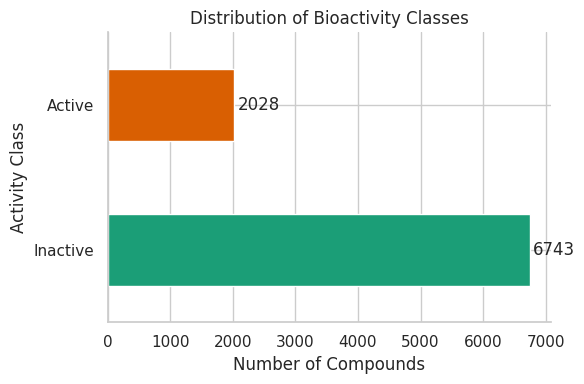

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

# Set plot style
sns.set_style("whitegrid")

# Count per class
class_counts = df['Class'].value_counts().sort_index()  # ensures 0,1 order

# Plot horizontal bar chart
plt.figure(figsize=(6,4))
class_counts.plot(kind='barh', color=sns.color_palette('Dark2', n_colors=len(class_counts)))

# Remove top and right spines
plt.gca().spines[['top', 'right']].set_visible(False)

# Add labels
plt.xlabel("Number of Compounds")
plt.ylabel("Activity Class")
plt.yticks([0,1], ["Inactive", "Active"])  # optionally label classes
plt.title("Distribution of Bioactivity Classes")

# Show values on bars
for i, v in enumerate(class_counts):
    plt.text(v + 50, i, str(v), va='center')

plt.tight_layout()
plt.show()

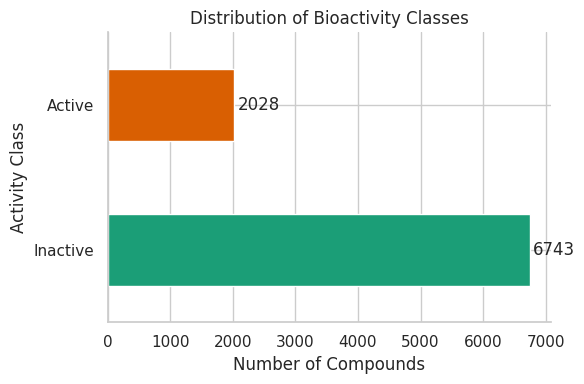

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

# Set plot style
sns.set_style("whitegrid")

# Count per class
class_counts = df['Class'].value_counts().sort_index()  # ensures 0,1 order

# Plot horizontal bar chart
plt.figure(figsize=(6,4))
class_counts.plot(kind='barh', color=sns.color_palette('Dark2', n_colors=len(class_counts)))

# Remove top and right spines
plt.gca().spines[['top', 'right']].set_visible(False)

# Add labels
plt.xlabel("Number of Compounds")
plt.ylabel("Activity Class")
plt.yticks([0,1], ["Inactive", "Active"])  # optionally label classes
plt.title("Distribution of Bioactivity Classes")

# Show values on bars
for i, v in enumerate(class_counts):
    plt.text(v + 50, i, str(v), va='center')

plt.tight_layout()
plt.show()


##### Modred

In [ ]:
pip install mordred rdkit-pypi

ERROR: Could not find a version that satisfies the requirement rdkit-pypi (from versions: none)
ERROR: No matching distribution found for rdkit-pypi


In [ ]:
from rdkit import Chem
from mordred import Calculator, descriptors

In [ ]:
# Convert SMILES to Mol objects
df['mol'] = df['canonical_smiles'].apply(Chem.MolFromSmiles)

In [ ]:
# Optional: check for invalid SMILES
invalid_mols = df['mol'].isna().sum()
print(f"Number of invalid SMILES: {invalid_mols}")

Number of invalid SMILES: 0


In [ ]:
calc = Calculator(descriptors, ignore_3D=True)  # ignore 3D descriptors

In [ ]:
# feature calculation
X = calc.pandas(df['mol'])

100%|██████████| 8771/8771 [38:31<00:00,  3.79it/s]


In [ ]:
# feature calculation
X = calc.pandas(df['mol'])

100%|██████████| 8771/8771 [39:36<00:00,  3.69it/s]


In [ ]:
df['morgan_fp'] = df['mol'].apply(
    lambda x: AllChem.GetMorganFingerprintAsBitVect(x, radius=2, nBits=2048)
)


Streaming output truncated to the last 5000 lines.
[17:23:04] DEPRECATION WARNING: please use MorganGenerator
[17:23:04] DEPRECATION WARNING: please use MorganGenerator
[17:23:04] DEPRECATION WARNING: please use MorganGenerator
[17:23:04] DEPRECATION WARNING: please use MorganGenerator
[17:23:04] DEPRECATION WARNING: please use MorganGenerator
[17:23:04] DEPRECATION WARNING: please use MorganGenerator
[17:23:04] DEPRECATION WARNING: please use MorganGenerator
[17:23:04] DEPRECATION WARNING: please use MorganGenerator
[17:23:04] DEPRECATION WARNING: please use MorganGenerator
[17:23:04] DEPRECATION WARNING: please use MorganGenerator
[17:23:04] DEPRECATION WARNING: please use MorganGenerator
[17:23:04] DEPRECATION WARNING: please use MorganGenerator
[17:23:04] DEPRECATION WARNING: please use MorganGenerator
[17:23:04] DEPRECATION WARNING: please use MorganGenerator
[17:23:04] DEPRECATION WARNING: please use MorganGenerator
[17:23:04] DEPRECATION WARNING: please use MorganGenerator
[17:2

In [ ]:
df

In [ ]:
df.head()

canonical_smiles  standard_value  \
0  CN(CNC(=O)c1cccc(S(=O)(=O)N2CCOCC2)c1)c1cc(Cl)...         9.50000   
1  COc1ccccc1-c1cc2nc(-c3ccccc3)cc(N3CCN(C(=O)c4c...         5.66100   
2  COC(=O)N1c2ccc3c(nc(C(F)(F)F)n3Cc3ccccc3)c2CC[...         0.55000   
3  COC(=O)C1=CC2(CC1)CCN(C(=O)c1ccc(NC(=O)c3cc(F)...         0.11500   
4  COc1ccc(-c2ccc3ccn(-c4nn(C5CCOCC5)c5c4CN(C(C)=...         0.00674   

   pchembl_value  Class                                               mol  \
0           5.02      1  <rdkit.Chem.rdchem.Mol object at 0x7b71866b3c30>   
1           5.25      1  <rdkit.Chem.rdchem.Mol object at 0x7b71866a5770>   
2           6.26      0  <rdkit.Chem.rdchem.Mol object at 0x7b71866a7760>   
3           7.06      0  <rdkit.Chem.rdchem.Mol object at 0x7b71866a5540>   
4           8.17      0  <rdkit.Chem.rdchem.Mol object at 0x7b71866a5460>   

                                         Fingerprint  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                           morgan_fp  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

In [ ]:
from rdkit.DataStructs import BulkTanimotoSimilarity
import numpy as np

fps = list(df['morgan_fp'])
tanimoto_values = []

for i in range(len(fps)):
    sims = BulkTanimotoSimilarity(fps[i], fps[i+1:])
    tanimoto_values.extend(sims)

tanimoto_values = np.array(tanimoto_values)

In [ ]:
tanimoto_values

array([0.13861386, 0.14285714, 0.17142857, ..., 0.10144928, 0.11971831,
       0.07258065])

In [ ]:
tanimoto_values

array([0.13861386, 0.14285714, 0.17142857, ..., 0.10144928, 0.11971831,
       0.07258065])

In [ ]:
# 4. Statistics
print("Mean Tanimoto:", tanimoto_values.mean())
print("Std Tanimoto:", tanimoto_values.std())
print("Min:", tanimoto_values.min())
print("Max:", tanimoto_values.max())

Mean Tanimoto: 0.12610219874249617
Std Tanimoto: 0.048424392355481315
Min: 0.0
Max: 1.0


In [ ]:
# 4. Statistics
print("Mean Tanimoto:", tanimoto_values.mean())
print("Std Tanimoto:", tanimoto_values.std())
print("Min:", tanimoto_values.min())
print("Max:", tanimoto_values.max())

Mean Tanimoto: 0.12610219874249617
Std Tanimoto: 0.048424392355481315
Min: 0.0
Max: 1.0


In [ ]:
len(tanimoto_values)  # Should be ~N*(N-1)/2 = 38,493,535
print("Mean Tanimoto:", np.mean(tanimoto_values))
print("Std Tanimoto:", np.std(tanimoto_values))
print("Min:", np.min(tanimoto_values))
print("Max:", np.max(tanimoto_values))

Mean Tanimoto: 0.12610219874249617
Std Tanimoto: 0.048424392355481315
Min: 0.0
Max: 1.0


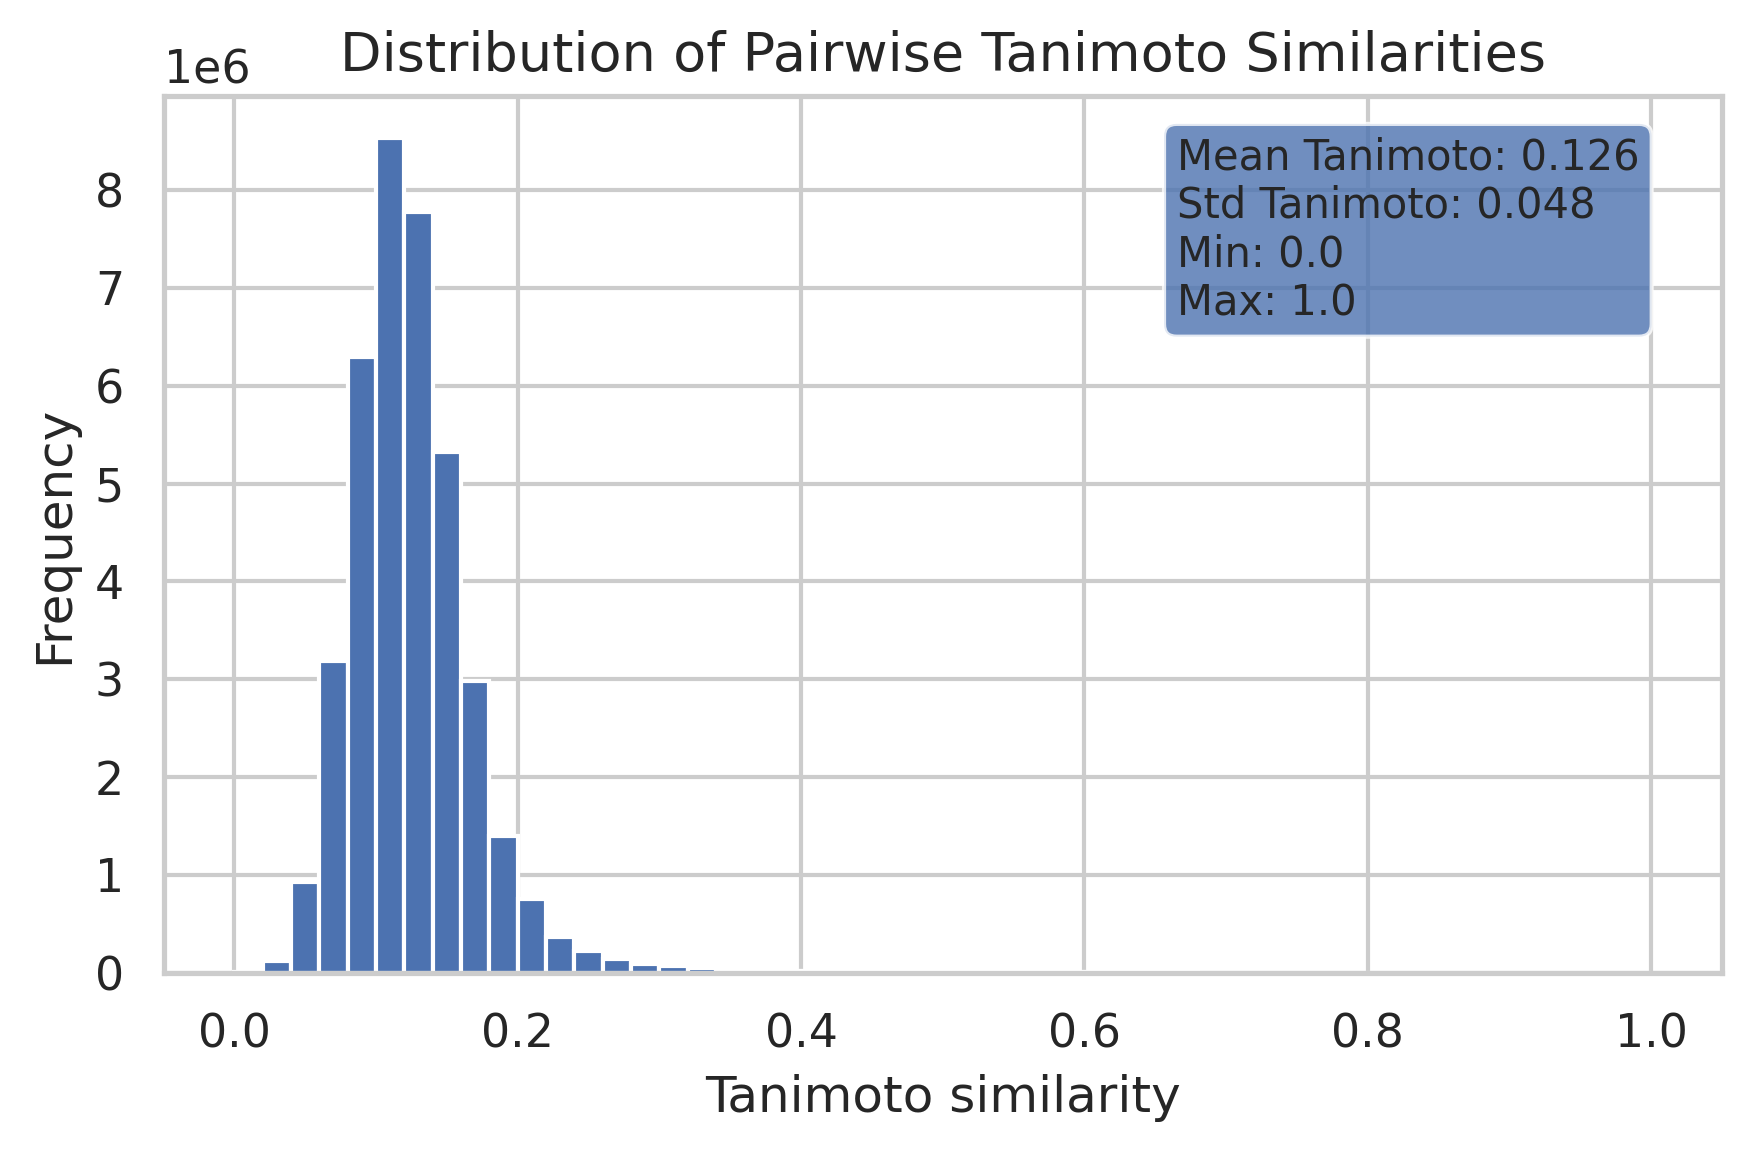

In [ ]:
import matplotlib.pyplot as plt

# Create figure with 300 DPI
plt.figure(figsize=(6, 4), dpi=300)

plt.hist(tanimoto_values, bins=50)
plt.xlabel("Tanimoto similarity", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of Pairwise Tanimoto Similarities", fontsize=13)

# Text to display
stats_text = (
    "Mean Tanimoto: 0.126\n"
    "Std Tanimoto: 0.048\n"
    "Min: 0.0\n"
    "Max: 1.0"
)

# Add text box inside the plot
plt.text(
    0.65, 0.75, stats_text,
    transform=plt.gca().transAxes,
    fontsize=10,
    bbox=dict(boxstyle="round", alpha=0.8)
)

# Tight layout for publication
plt.tight_layout()

# Save figure at 300 DPI
plt.savefig("tanimoto_similarity_distribution.png", dpi=300, bbox_inches="tight")

plt.show()

In [ ]:
# Identify pairs with Tanimoto = 1
high_sim_idx = np.where(tanimoto_values == 1)[0]
print(f"Number of identical pairs: {len(high_sim_idx)}")

Number of identical pairs: 200


In [ ]:
# Identify pairs with Tanimoto = 1
high_sim_idx = np.where(tanimoto_values == 1)[0]
print(f"Number of identical pairs: {len(high_sim_idx)}")

Number of identical pairs: 200


In [ ]:
df[df.duplicated(subset='canonical_smiles', keep=False)]


Empty DataFrame
Columns: [canonical_smiles, standard_value, pchembl_value, Class, mol, Fingerprint, morgan_fp]
Index: []

In [ ]:
print(df.shape)
print(df.columns)

(8771, 6)
Index(['canonical_smiles', 'standard_value', 'pchembl_value', 'Class', 'mol',
       'morgan_fp'],
      dtype='object')


In [ ]:
print(df.shape)
print(df.columns)


(8771, 7)
Index(['canonical_smiles', 'standard_value', 'pchembl_value', 'Class', 'mol',
       'Fingerprint', 'morgan_fp'],
      dtype='object')


In [ ]:
duplicates = df[df.duplicated(subset='canonical_smiles', keep=False)]
print(f"Number of duplicate SMILES: {len(duplicates)}")

Number of duplicate SMILES: 0


In [ ]:
print(X.shape)  # Should match number of compounds (8771) by number of descriptors
print(X.head())

(8771, 1613)
                                                 ABC  \
0  module 'numpy' has no attribute 'float'.\n`np....   
1  module 'numpy' has no attribute 'float'.\n`np....   
2  module 'numpy' has no attribute 'float'.\n`np....   
3  module 'numpy' has no attribute 'float'.\n`np....   
4  module 'numpy' has no attribute 'float'.\n`np....   

                                               ABCGG  nAcid  nBase    SpAbs_A  \
0  module 'numpy' has no attribute 'float'.\n`np....      0      0  37.227109   
1  module 'numpy' has no attribute 'float'.\n`np....      0      0  49.107385   
2  module 'numpy' has no attribute 'float'.\n`np....      0      0  37.060889   
3  module 'numpy' has no attribute 'float'.\n`np....      0      0   49.51725   
4  module 'numpy' has no attribute 'float'.\n`np....      0      0  47.184115   

    SpMax_A  SpDiam_A     SpAD_A   SpMAD_A   LogEE_A     VE1_A     VE2_A  \
0  2.430188  4.860375  37.227109  1.283693   4.28496  4.147306  0.143011   
1  2.519734

In [ ]:
print(X.shape)  # Should match number of compounds (8771) by number of descriptors
print(X.head())

(8771, 1613)
                                                 ABC  \
0  module 'numpy' has no attribute 'float'.\n`np....   
1  module 'numpy' has no attribute 'float'.\n`np....   
2  module 'numpy' has no attribute 'float'.\n`np....   
3  module 'numpy' has no attribute 'float'.\n`np....   
4  module 'numpy' has no attribute 'float'.\n`np....   

                                               ABCGG  nAcid  nBase    SpAbs_A  \
0  module 'numpy' has no attribute 'float'.\n`np....      0      0  37.227109   
1  module 'numpy' has no attribute 'float'.\n`np....      0      0  49.107385   
2  module 'numpy' has no attribute 'float'.\n`np....      0      0  37.060889   
3  module 'numpy' has no attribute 'float'.\n`np....      0      0   49.51725   
4  module 'numpy' has no attribute 'float'.\n`np....      0      0  47.184115   

    SpMax_A  SpDiam_A     SpAD_A   SpMAD_A   LogEE_A     VE1_A     VE2_A  \
0  2.430188  4.860375  37.227109  1.283693   4.28496  4.147306  0.143011   
1  2.519734

In [ ]:
from sklearn.model_selection import train_test_split

# Target variable
y = df['Class']

# Ensure X has the correct shape
print(X.shape)  # Should be (8771, number_of_features)
print(len(y))   # Should be 8771

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Check shapes
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(8771, 1613)
8771
(6139, 1613) (2632, 1613)
(6139,) (2632,)


In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')  # or strategy='median'
X_array_imputed = imputer.fit_transform(X_array)

# Now standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_array_imputed)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Step 0: Ensure X is a numeric array
X_array = np.array(X, dtype=float)  # convert to float, force numeric
y_array = np.array(y)

# Step 1: Replace inf or -inf with NaN
X_array[np.isinf(X_array)] = np.nan

# Step 2: Impute missing values (NaN) using mean
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X_array)

# Step 3: Standardize features (z-score)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Step 4: KMeans clustering
optimal_k = 10  # or determine with elbow
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled)

# Step 5: Proportional train/test split
test_size = 0.3
train_indices = []
test_indices = []

for cluster in np.unique(cluster_labels):
    cluster_idx = np.where(cluster_labels == cluster)[0]
    n_test = int(len(cluster_idx) * test_size)

    np.random.seed(42)
    test_idx_cluster = np.random.choice(cluster_idx, size=n_test, replace=False)
    train_idx_cluster = np.setdiff1d(cluster_idx, test_idx_cluster)

    test_indices.extend(test_idx_cluster)
    train_indices.extend(train_idx_cluster)

# Step 6: Create train/test sets
X_train = X_imputed[train_indices]
X_test = X_imputed[test_indices]
y_train = y_array[train_indices]
y_test = y_array[test_indices]

# Step 7: Check
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)
print("Train class distribution:\n", pd.Series(y_train).value_counts(normalize=True))
print("Test class distribution:\n", pd.Series(y_test).value_counts(normalize=True))


Train shape: (6144, 1521) (6144,)
Test shape: (2627, 1521) (2627,)
Train class distribution:
 0    0.76709
1    0.23291
Name: proportion, dtype: float64
Test class distribution:
 0    0.772745
1    0.227255
Name: proportion, dtype: float64


In [ ]:
from rdkit.Chem import Descriptors

def count_ro5_violations(mol):
    violations = 0
    # Molecular weight > 500
    if Descriptors.MolWt(mol) > 500:
        violations += 1
    # logP > 5
    if Descriptors.MolLogP(mol) > 5:
        violations += 1
    # H-bond donors > 5
    if Descriptors.NumHDonors(mol) > 5:
        violations += 1
    # H-bond acceptors > 10
    if Descriptors.NumHAcceptors(mol) > 10:
        violations += 1
    return violations

# Apply to train and test sets
df['ro5_violations'] = df['mol'].apply(count_ro5_violations)

train_ro5 = df.iloc[train_indices]['ro5_violations']
test_ro5 = df.iloc[test_indices]['ro5_violations']

In [ ]:
import pandas as pd

# Subset training data
train_df = df.iloc[train_indices].copy()

# Separate active and inactive
active_train = train_df[train_df['Class'] == 1]
inactive_train = train_df[train_df['Class'] == 0]

# Percentage with ZERO Ro5 violations
active_zero = (active_train['ro5_violations'] == 0).mean() * 100
inactive_zero = (inactive_train['ro5_violations'] == 0).mean() * 100

print(f"Active compounds with zero Ro5 violations: {active_zero:.1f}%")
print(f"Inactive compounds with zero Ro5 violations: {inactive_zero:.1f}%")

Active compounds with zero Ro5 violations: 74.8%
Inactive compounds with zero Ro5 violations: 67.3%


In [ ]:
import pandas as pd

# Subset training data
train_df = df.iloc[train_indices].copy()

# Separate active and inactive
active_train = train_df[train_df['Class'] == 1]
inactive_train = train_df[train_df['Class'] == 0]

# Percentage with ZERO Ro5 violations
active_zero = (active_train['ro5_violations'] == 0).mean() * 100
inactive_zero = (inactive_train['ro5_violations'] == 0).mean() * 100

print(f"Active compounds with zero Ro5 violations: {active_zero:.1f}%")
print(f"Inactive compounds with zero Ro5 violations: {inactive_zero:.1f}%")


Active compounds with zero Ro5 violations: 74.8%
Inactive compounds with zero Ro5 violations: 67.3%


In [ ]:
# Count violations
active_counts = active_train['ro5_violations'].value_counts().sort_index()
inactive_counts = inactive_train['ro5_violations'].value_counts().sort_index()

# Align categories
all_levels = sorted(set(active_counts.index).union(inactive_counts.index))
active_counts = active_counts.reindex(all_levels, fill_value=0)
inactive_counts = inactive_counts.reindex(all_levels, fill_value=0)

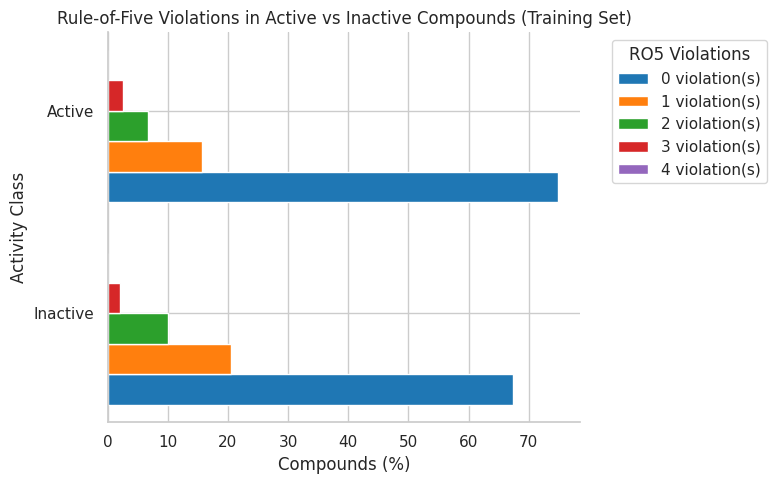

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Prepare training DataFrame
df_train = pd.DataFrame({
    'RO5_violations': train_ro5,
    'Activity': y_train  # 0 = Inactive, 1 = Active
})

# Count RO5 violations per activity
counts = df_train.groupby(['Activity', 'RO5_violations']).size().unstack(fill_value=0)

# Convert to percentages
counts_percent = counts.div(counts.sum(axis=1), axis=0) * 100

# Labels
activities = ['Inactive', 'Active']
violations = counts_percent.columns

# Plot style
sns.set_style("whitegrid")
colors = sns.color_palette("tab10", n_colors=len(violations))

plt.figure(figsize=(8, 5))

y = np.arange(len(activities))
bar_height = 0.15

# Plot stacked horizontal bars (side-by-side feel)
for i, v in enumerate(violations):
    plt.barh(
        y + i * bar_height,
        counts_percent[v],
        height=bar_height,
        color=colors[i],
        label=f"{v} violation(s)"
    )

# Formatting
plt.yticks(y + bar_height * (len(violations) / 2), activities)
plt.xlabel("Compounds (%)")
plt.ylabel("Activity Class")
plt.title("Rule-of-Five Violations in Active vs Inactive Compounds (Training Set)")

# Clean spines
plt.gca().spines[['top', 'right']].set_visible(False)

# Legend
plt.legend(title="RO5 Violations", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

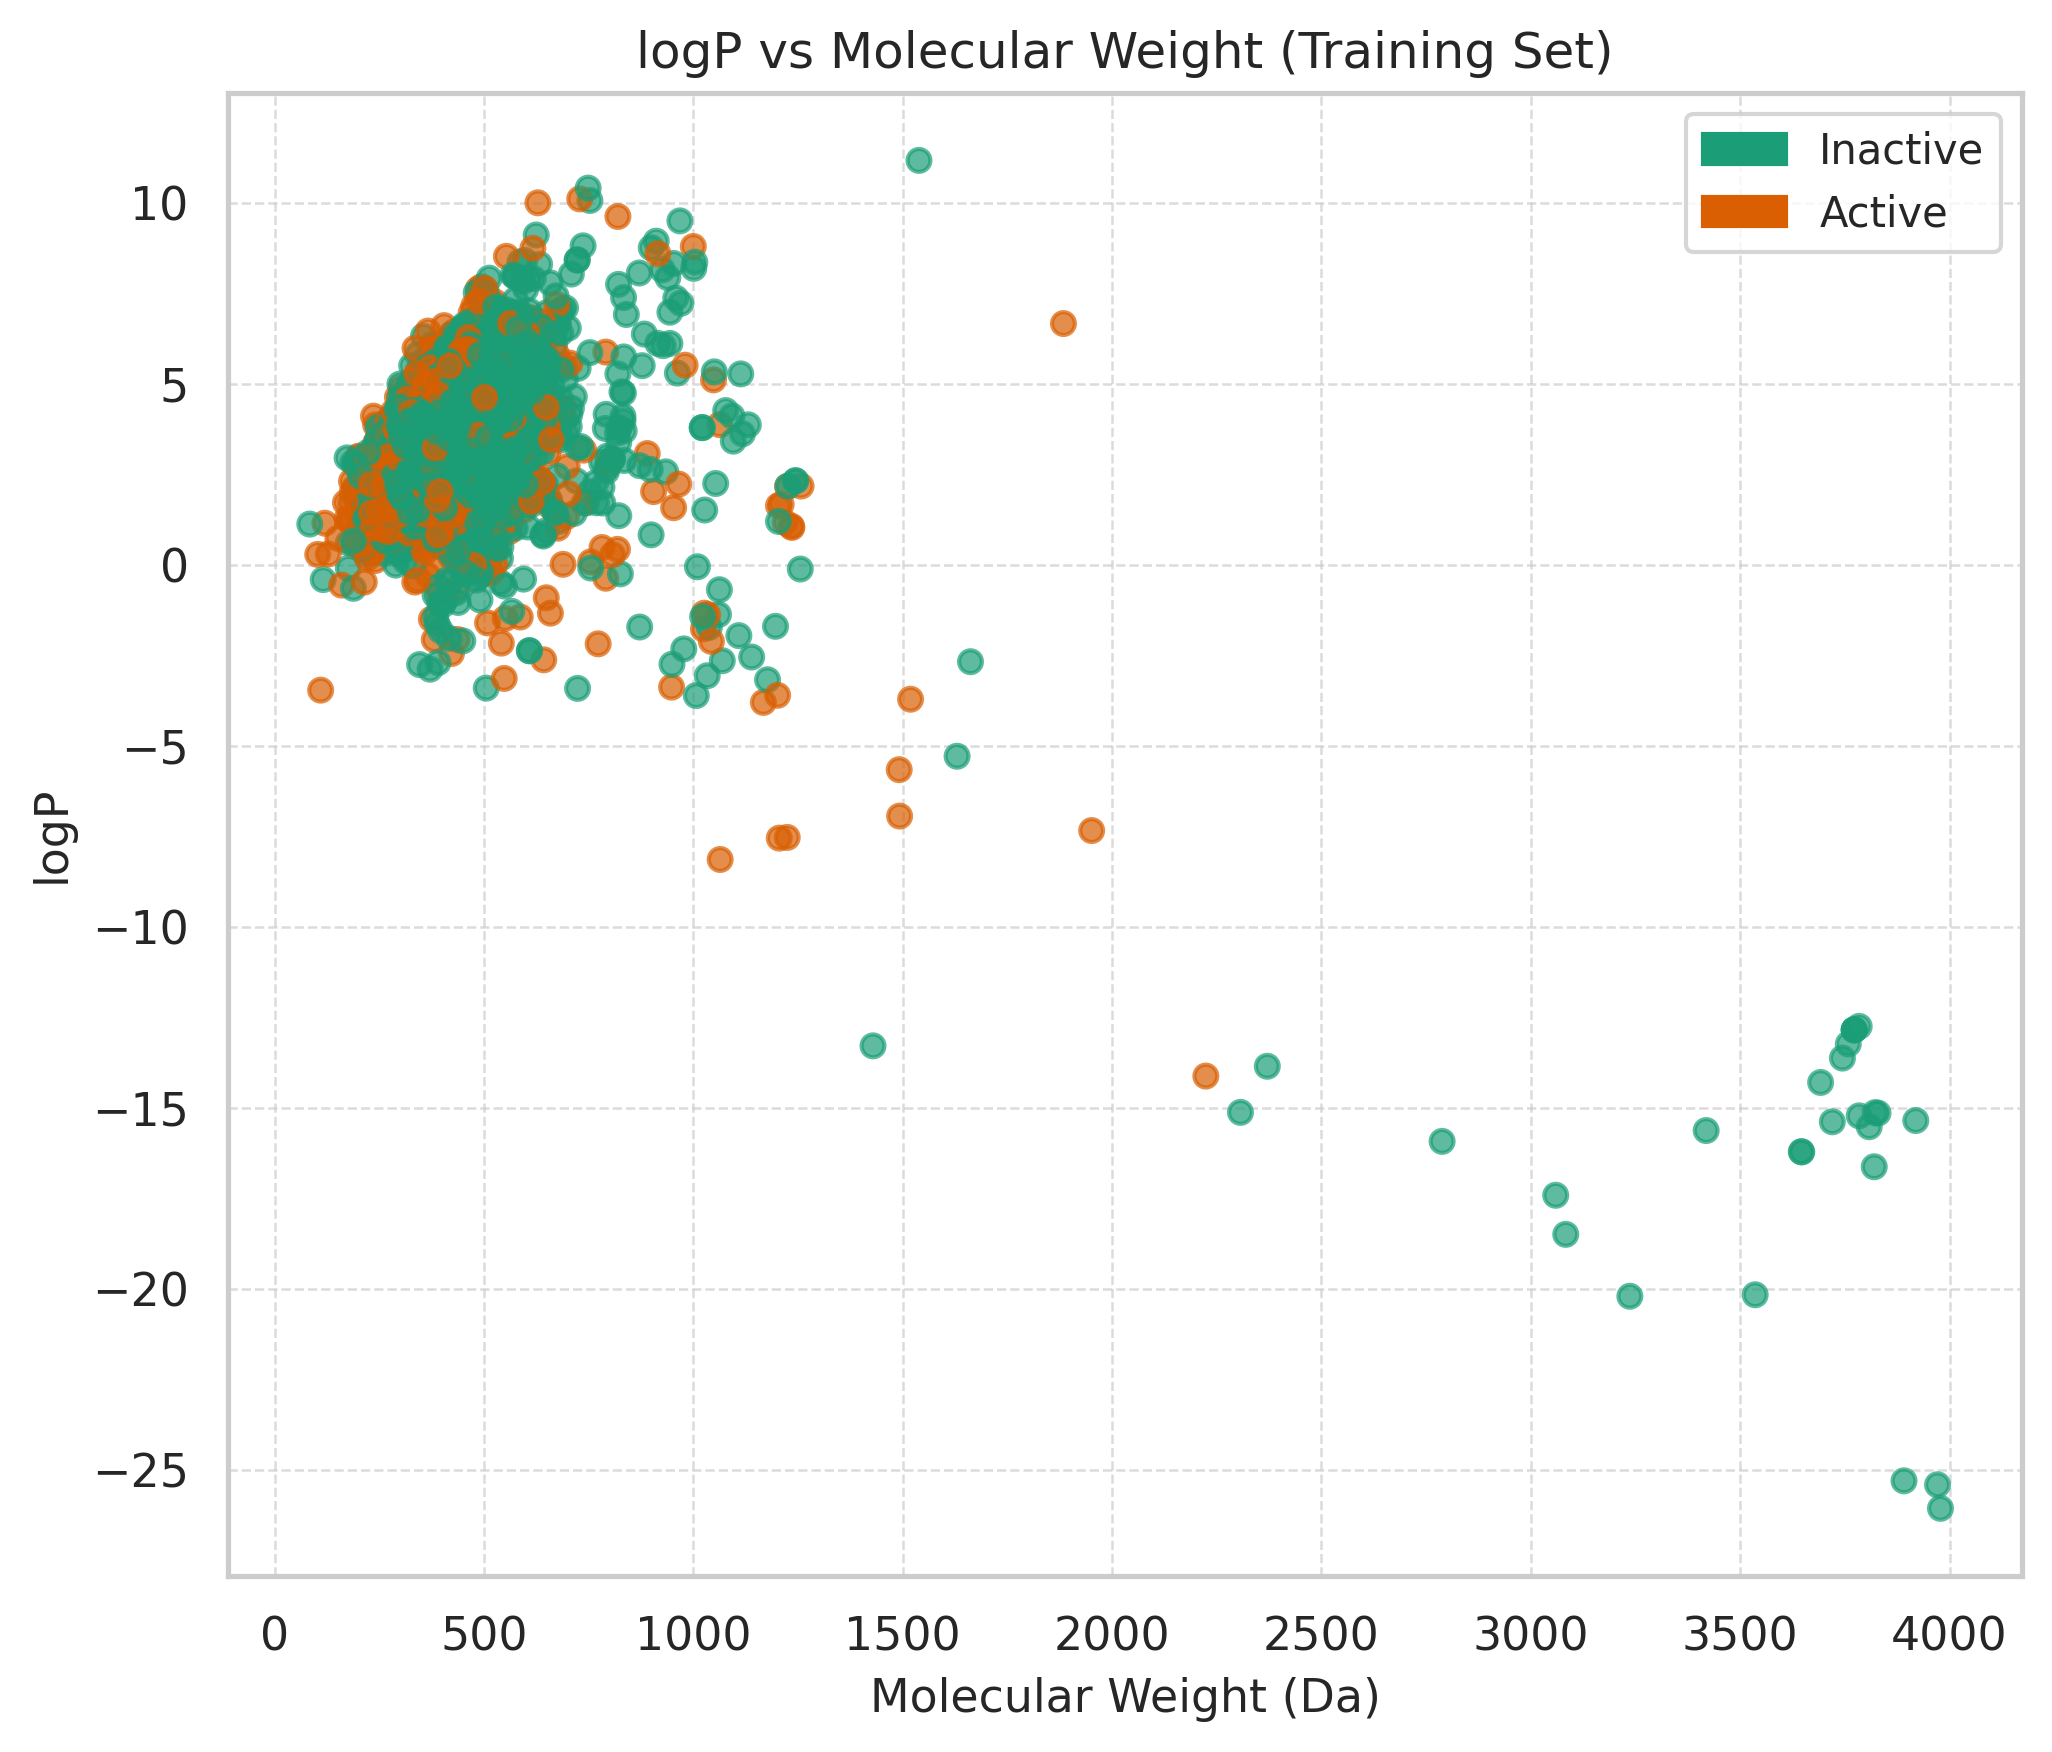

In [ ]:
### very needed
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit.Chem import Descriptors

# Set Seaborn style
sns.set_style("whitegrid")

# Training set data
train_mw = df.iloc[train_indices]['mol'].apply(Descriptors.MolWt)
train_logp = df.iloc[train_indices]['mol'].apply(Descriptors.MolLogP)
train_activity = y_train  # 0=Inactive, 1=Active

# Colors by activity
palette = sns.color_palette("Dark2", n_colors=2)
train_colors = [palette[i] for i in train_activity]

plt.figure(figsize=(7, 6), dpi=300)  # high-res

# Scatter plot for training set
plt.scatter(
    train_mw, train_logp,
    c=train_colors,
    alpha=0.7, s=30
)

# Labels and title
plt.xlabel("Molecular Weight (Da)", fontsize=11)
plt.ylabel("logP", fontsize=11)
plt.title("logP vs Molecular Weight (Training Set)", fontsize=12)

# Optional: legend
import matplotlib.patches as mpatches
inactive_patch = mpatches.Patch(color=palette[0], label='Inactive')
active_patch = mpatches.Patch(color=palette[1], label='Active')
plt.legend(handles=[inactive_patch, active_patch], fontsize=10)

# Grid
plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.feature_selection import mutual_info_classif

def select_top_features(X, y, k):
    mi = mutual_info_classif(X, y, random_state=42)
    top_idx = np.argsort(mi)[-k:]  # indices of top k features
    return top_idx

# Example for 10, 30, 50 features
top_features_10 = select_top_features(X_train, y_train, 10)
top_features_30 = select_top_features(X_train, y_train, 30)
top_features_50 = select_top_features(X_train, y_train, 50)

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN  # undersampling + SMOTE combined

def apply_sampling(X, y, strategy='none'):
    if strategy == 'undersample':
        rus = RandomUnderSampler(random_state=42)
        X_res, y_res = rus.fit_resample(X, y)
    elif strategy == 'smote':
        sm = SMOTE(k_neighbors=3, random_state=42)
        X_res, y_res = sm.fit_resample(X, y)
    elif strategy == 'under+smote':
        smote_enn = SMOTEENN(random_state=42)
        X_res, y_res = smote_enn.fit_resample(X, y)
    else:
        X_res, y_res = X, y
    return X_res, y_res

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

models = {
    'LR': LogisticRegression(max_iter=1000, random_state=42),
    'RF': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'MLP': MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
}

def train_evaluate(X_train, y_train, X_test, y_test):
    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
        results[name] = {
            'accuracy': accuracy_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred),
            'auc': roc_auc_score(y_test, y_prob) if y_prob is not None else None
        }
    return results


In [ ]:
feature_sets = {
    10: top_features_10,
    30: top_features_30,
    50: top_features_50
}

sampling_strategies = ['undersample', 'smote', 'under+smote']

final_results = {}

for k, features in feature_sets.items():
    X_train_k = X_train[:, features]
    X_test_k = X_test[:, features]

    for strategy in sampling_strategies:
        X_res, y_res = apply_sampling(X_train_k, y_train, strategy=strategy)
        key = f'{k}features_{strategy}'
        final_results[key] = train_evaluate(X_res, y_res, X_test_k, y_test)

# Example: print results
for k, res in final_results.items():
    print(f'\n=== {k} ===')
    for model_name, metrics in res.items():
        print(f'{model_name}: {metrics}')



=== 10features_undersample ===
LR: {'accuracy': 0.6075371145793681, 'f1': 0.4171848501978519, 'auc': 0.6491154458664422}
RF: {'accuracy': 0.7247811191473164, 'f1': 0.540952380952381, 'auc': 0.7920043567591653}
SVM: {'accuracy': 0.6566425580510088, 'f1': 0.4142857142857143, 'auc': 0.6568227013557112}
MLP: {'accuracy': 0.6699657403882756, 'f1': 0.4262078093977498, 'auc': 0.670131032832471}

=== 10features_smote ===
LR: {'accuracy': 0.6162923486867149, 'f1': 0.4233409610983982, 'auc': 0.6513053774620228}
RF: {'accuracy': 0.8005329272934907, 'f1': 0.5474956822107081, 'auc': 0.8048633974470052}
SVM: {'accuracy': 0.6593071945184621, 'f1': 0.4176968119713728, 'auc': 0.6580241107012897}
MLP: {'accuracy': 0.6619718309859155, 'f1': 0.42930591259640105, 'auc': 0.6660597734155177}

=== 10features_under+smote ===
LR: {'accuracy': 0.5892653216596878, 'f1': 0.4195804195804196, 'auc': 0.6526891435832695}
RF: {'accuracy': 0.7518081461743433, 'f1': 0.518463810930576, 'auc': 0.7733041232434752}
SVM: {'a

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score

# Define sampling strategies
def apply_sampling(X, y, strategy):
    if strategy == 'SMOTE':
        sm = SMOTE(k_neighbors=3, random_state=42)
        return sm.fit_resample(X, y)
    elif strategy == 'Undersampling':
        rus = RandomUnderSampler(random_state=42)
        return rus.fit_resample(X, y)
    elif strategy == 'Undersampling+SMOTE':
        smote_enn = SMOTEENN(random_state=42)
        return smote_enn.fit_resample(X, y)
    else:
        return X, y

# Define models
models = {
    'LR': LogisticRegression(max_iter=1000, random_state=42),
    'RF': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'MLP': MLPClassifier(hidden_layer_sizes=(50,50), max_iter=500, random_state=42)
}

# Feature sets
feature_sets = {
    10: top_features_10,
    30: top_features_30,
    50: top_features_50
}

# Sampling strategies
sampling_methods = ['SMOTE', 'Undersampling', 'Undersampling+SMOTE']

# Store results
results = []

for num_feat, features in feature_sets.items():
    X_train_f, X_test_f = X_train[:, features], X_test[:, features]

    for sampling in sampling_methods:
        X_res, y_res = apply_sampling(X_train_f, y_train, sampling)

        for model_name, model in models.items():
            model.fit(X_res, y_res)
            y_pred = model.predict(X_test_f)

            results.append({
                'Model': model_name,
                'Number of Features': num_feat,
                'Sampling Method': sampling,
                'Precision': round(precision_score(y_test, y_pred), 2),
                'Accuracy': round(accuracy_score(y_test, y_pred), 2),
                'Recall': round(recall_score(y_test, y_pred), 2),
                'F1 score': round(f1_score(y_test, y_pred), 2)
            })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Sort for readability (optional)
results_df = results_df.sort_values(by=['Model', 'Number of Features', 'Sampling Method'], ascending=[True, False, True])

# Show table like your example
print(results_df)

   Model  Number of Features      Sampling Method  Precision  Accuracy  \
24    LR                  50                SMOTE       0.35      0.65   
28    LR                  50        Undersampling       0.35      0.65   
32    LR                  50  Undersampling+SMOTE       0.31      0.56   
12    LR                  30                SMOTE       0.34      0.64   
16    LR                  30        Undersampling       0.33      0.62   
20    LR                  30  Undersampling+SMOTE       0.30      0.54   
0     LR                  10                SMOTE       0.32      0.62   
4     LR                  10        Undersampling       0.31      0.61   
8     LR                  10  Undersampling+SMOTE       0.31      0.59   
27   MLP                  50                SMOTE       0.37      0.68   
31   MLP                  50        Undersampling       0.39      0.70   
35   MLP                  50  Undersampling+SMOTE       0.39      0.70   
15   MLP                  30          

####Machine Learning Model Development and Evaluation

In [ ]:
# IMPORTS

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN


# STEP 0: LOAD DATA & NUMERIC CONVERSION

# df = pd.read_csv("your_dataset.csv")  # Load your dataset
X = df.drop(columns=['Class']).apply(pd.to_numeric, errors='coerce').values  # Convert non-numeric to NaN
y = df['Class'].values


# STEP 1: CLEAN, IMPUTE, SCALE

# Replace inf/-inf with NaN
X = np.where(np.isfinite(X), X, np.nan)

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)


# STEP 2: TRAIN/TEST SPLIT

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, stratify=y, random_state=42
)


# STEP 3: FEATURE SELECTION

def select_top_features(X, y, k):
    mi = mutual_info_classif(X, y, random_state=42)
    top_idx = np.argsort(mi)[-k:]
    return top_idx

top_features = {
    10: select_top_features(X_train, y_train, 10),
    30: select_top_features(X_train, y_train, 30),
    50: select_top_features(X_train, y_train, 50)
}

# ===============================
# STEP 4: SAMPLING FUNCTIONS
# ===============================
def apply_sampling(X, y, strategy='none'):
    if strategy == 'Undersampling':
        rus = RandomUnderSampler(random_state=42)
        X_res, y_res = rus.fit_resample(X, y)
    elif strategy == 'SMOTE':
        sm = SMOTE(k_neighbors=3, random_state=42)
        X_res, y_res = sm.fit_resample(X, y)
    elif strategy == 'Undersampling+SMOTE':
        smote_enn = SMOTEENN(random_state=42)
        X_res, y_res = smote_enn.fit_resample(X, y)
    else:
        X_res, y_res = X, y
    return X_res, y_res


# STEP 5: HYPERPARAMETER TUNING

def optimize_rf(X, y):
    param_dist = {
        'n_estimators': np.arange(200, 2001, 200),
        'max_depth': np.arange(10, 111, 10),
        'min_samples_split': [2, 5, 10, 15, 20],
        'min_samples_leaf': [1, 2, 4, 8],
        'bootstrap': [True, False]
    }
    rf = RandomForestClassifier(random_state=42)
    rs = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=50, cv=3, scoring='roc_auc', n_jobs=-1, random_state=42)
    rs.fit(X, y)
    return rs.best_estimator_

def optimize_svm(X, y):
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'gamma': [0.001, 0.01, 0.1, 1, 10],
        'kernel': ['rbf']
    }
    svc = SVC(probability=True, random_state=42)
    gs = GridSearchCV(svc, param_grid=param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
    gs.fit(X, y)
    return gs.best_estimator_

def optimize_mlp(X, y, input_size):
    param_grid = {
        'hidden_layer_sizes': [(input_size//2, input_size//2), (input_size, input_size), (input_size*2, input_size*2)],
        'alpha': [0, 0.01, 0.001, 0.0001],
        'batch_size': [32, 64, 128],
        'learning_rate_init': [0.1, 0.01, 0.001, 0.0001]
    }
    mlp = MLPClassifier(max_iter=10, random_state=42)
    gs = GridSearchCV(mlp, param_grid=param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
    gs.fit(X, y)
    return gs.best_estimator_

#
# STEP 6: OPTIMAL THRESHOLD (Youden's J)

def optimal_threshold(model, X_train, y_train, rounds=100):
    thresholds = []
    n_samples = X_train.shape[0]
    for i in range(rounds):
        np.random.seed(i)
        idx = np.random.choice(n_samples, size=int(0.8*n_samples), replace=False)
        X_sub, y_sub = X_train[idx], y_train[idx]
        X_val, y_val = np.delete(X_train, idx, axis=0), np.delete(y_train, idx)
        model.fit(X_sub, y_sub)
        probs = model.predict_proba(X_val)[:, 1]
        fpr, tpr, thr = roc_curve(y_val, probs)
        J = tpr - fpr
        thresholds.append(thr[np.argmax(J)])
    return np.mean(thresholds)


# STEP 7: PCA

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


# STEP 8: TRAIN AND EVALUATE

sampling_strategies = ['SMOTE', 'Undersampling', 'Undersampling+SMOTE']
feature_sets_list = [10, 30, 50]

results = []

for k in feature_sets_list:
    features = top_features[k]
    X_train_k, X_test_k = X_train[:, features], X_test[:, features]
    input_size = X_train_k.shape[1]

    for strategy in sampling_strategies:
        X_res, y_res = apply_sampling(X_train_k, y_train, strategy)

        # Hyperparameter-optimized models
        rf_best = optimize_rf(X_res, y_res)
        svm_best = optimize_svm(X_res, y_res)
        mlp_best = optimize_mlp(X_res, y_res, input_size)
        lr = LogisticRegression(max_iter=1000, random_state=42)
        lr.fit(X_res, y_res)

        # Optimal thresholds
        rf_thresh = optimal_threshold(rf_best, X_res, y_res)
        svm_thresh = optimal_threshold(svm_best, X_res, y_res)
        mlp_thresh = optimal_threshold(mlp_best, X_res, y_res)
        lr_thresh = optimal_threshold(lr, X_res, y_res)

        # Evaluate
        for name, model, thresh in zip(
            ['RF', 'SVM', 'MLP', 'LR'],
            [rf_best, svm_best, mlp_best, lr],
            [rf_thresh, svm_thresh, mlp_thresh, lr_thresh]
        ):
            probs = model.predict_proba(X_test_k)[:, 1]
            y_pred = (probs >= thresh).astype(int)
            results.append({
                'Model': name,
                'Number of Features': k,
                'Sampling Method': strategy,
                'Precision': round(precision_score(y_test, y_pred), 2),
                'Accuracy': round(accuracy_score(y_test, y_pred), 2),
                'Recall': round(recall_score(y_test, y_pred), 2),
                'F1 score': round(f1_score(y_test, y_pred), 2),
                'AUC': round(roc_auc_score(y_test, probs), 2)
            })


# STEP 9: SAVE RESULTS

results_df = pd.DataFrame(results)
results_df.to_csv("model_results.csv", index=False)
print(results_df)


   Model  Number of Features      Sampling Method  Precision  Accuracy  \
0     RF                  10                SMOTE       1.00      1.00   
1    SVM                  10                SMOTE       1.00      1.00   
2    MLP                  10                SMOTE       1.00      1.00   
3     LR                  10                SMOTE       0.98      1.00   
4     RF                  10        Undersampling       1.00      1.00   
5    SVM                  10        Undersampling       1.00      1.00   
6    MLP                  10        Undersampling       0.96      0.99   
7     LR                  10        Undersampling       0.97      0.99   
8     RF                  10  Undersampling+SMOTE       1.00      1.00   
9    SVM                  10  Undersampling+SMOTE       0.99      1.00   
10   MLP                  10  Undersampling+SMOTE       0.96      0.99   
11    LR                  10  Undersampling+SMOTE       0.98      1.00   
12    RF                  30          

In [ ]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Sort by Accuracy in descending order
results_df = results_df.sort_values(by='Accuracy', ascending=False)

In [ ]:
print(results_df)

   Model  Number of Features      Sampling Method  Precision  Accuracy  \
0     RF                  10                SMOTE       1.00      1.00   
16    RF                  30        Undersampling       1.00      1.00   
33   SVM                  50  Undersampling+SMOTE       0.99      1.00   
32    RF                  50  Undersampling+SMOTE       1.00      1.00   
29   SVM                  50        Undersampling       1.00      1.00   
28    RF                  50        Undersampling       1.00      1.00   
27    LR                  50                SMOTE       0.98      1.00   
26   MLP                  50                SMOTE       1.00      1.00   
25   SVM                  50                SMOTE       1.00      1.00   
24    RF                  50                SMOTE       1.00      1.00   
23    LR                  30  Undersampling+SMOTE       0.98      1.00   
21   SVM                  30  Undersampling+SMOTE       0.99      1.00   
20    RF                  30  Undersam

In [ ]:
# Save to CSV
results_df.to_csv("model_results.csv", index=False)

# Display
print(results_df)

   Model  Number of Features      Sampling Method  Precision  Accuracy  \
0     RF                  10                SMOTE       1.00      1.00   
16    RF                  30        Undersampling       1.00      1.00   
33   SVM                  50  Undersampling+SMOTE       0.99      1.00   
32    RF                  50  Undersampling+SMOTE       1.00      1.00   
29   SVM                  50        Undersampling       1.00      1.00   
28    RF                  50        Undersampling       1.00      1.00   
27    LR                  50                SMOTE       0.98      1.00   
26   MLP                  50                SMOTE       1.00      1.00   
25   SVM                  50                SMOTE       1.00      1.00   
24    RF                  50                SMOTE       1.00      1.00   
23    LR                  30  Undersampling+SMOTE       0.98      1.00   
21   SVM                  30  Undersampling+SMOTE       0.99      1.00   
20    RF                  30  Undersam

In [3]:
!pip install python-docx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 5.8 MB/s eta 0:00:00


In [ ]:
# First, install python-docx if you haven't already
# !pip install python-docx

from docx import Document
from docx.shared import Inches
import pandas as pd

# Assume your DataFrame is called results_df
# results_df = pd.DataFrame(...)

# Create a new Word document
doc = Document()
doc.add_heading('PCA Results', 0)

# Optional: add a short description
doc.add_paragraph(
    'This table summarizes the results of the PCA analysis on training and test sets.'
)

# Add table
table = doc.add_table(rows=1, cols=len(results_df.columns))
table.style = 'Light List'  # you can change the style

# Add header row
hdr_cells = table.rows[0].cells
for i, col_name in enumerate(results_df.columns):
    hdr_cells[i].text = str(col_name)

# Add data rows
for index, row in results_df.iterrows():
    row_cells = table.add_row().cells
    for i, col_name in enumerate(results_df.columns):
        row_cells[i].text = str(row[col_name])

# Save the document
doc.save('PCA_results.docx')

print("Word document saved as 'PCA_results.docx'")

Word document saved as 'PCA_results.docx'


In [ ]:
# Redo
# IMPORTS

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN


# STEP 0: LOAD DATA & NUMERIC CONVERSION

# df = pd.read_csv("your_dataset.csv")  # Load your dataset
X = df.drop(columns=['Class']).apply(pd.to_numeric, errors='coerce').values  # Convert non-numeric to NaN
y = df['Class'].values


# STEP 1: CLEAN, IMPUTE, SCALE

# Replace inf/-inf with NaN
X = np.where(np.isfinite(X), X, np.nan)

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)


# STEP 2: TRAIN/TEST SPLIT

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, stratify=y, random_state=42
)


# STEP 3: FEATURE SELECTION

def select_top_features(X, y, k):
    mi = mutual_info_classif(X, y, random_state=42)
    top_idx = np.argsort(mi)[-k:]
    return top_idx

top_features = {
    10: select_top_features(X_train, y_train, 10),
    30: select_top_features(X_train, y_train, 30),
    50: select_top_features(X_train, y_train, 50)
}

# ===============================
# STEP 4: SAMPLING FUNCTIONS
# ===============================
def apply_sampling(X, y, strategy='none'):
    if strategy == 'Undersampling':
        rus = RandomUnderSampler(random_state=42)
        X_res, y_res = rus.fit_resample(X, y)
    elif strategy == 'SMOTE':
        sm = SMOTE(k_neighbors=3, random_state=42)
        X_res, y_res = sm.fit_resample(X, y)
    elif strategy == 'Undersampling+SMOTE':
        smote_enn = SMOTEENN(random_state=42)
        X_res, y_res = smote_enn.fit_resample(X, y)
    else:
        X_res, y_res = X, y
    return X_res, y_res


# STEP 5: HYPERPARAMETER TUNING

def optimize_rf(X, y):
    param_dist = {
        'n_estimators': np.arange(200, 2001, 200),
        'max_depth': np.arange(10, 111, 10),
        'min_samples_split': [2, 5, 10, 15, 20],
        'min_samples_leaf': [1, 2, 4, 8],
        'bootstrap': [True, False]
    }
    rf = RandomForestClassifier(random_state=42)
    rs = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=50, cv=3, scoring='roc_auc', n_jobs=-1, random_state=42)
    rs.fit(X, y)
    return rs.best_estimator_

def optimize_svm(X, y):
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'gamma': [0.001, 0.01, 0.1, 1, 10],
        'kernel': ['rbf']
    }
    svc = SVC(probability=True, random_state=42)
    gs = GridSearchCV(svc, param_grid=param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
    gs.fit(X, y)
    return gs.best_estimator_

def optimize_mlp(X, y, input_size):
    param_grid = {
        'hidden_layer_sizes': [(input_size//2, input_size//2), (input_size, input_size), (input_size*2, input_size*2)],
        'alpha': [0, 0.01, 0.001, 0.0001],
        'batch_size': [32, 64, 128],
        'learning_rate_init': [0.1, 0.01, 0.001, 0.0001]
    }
    mlp = MLPClassifier(max_iter=10, random_state=42)
    gs = GridSearchCV(mlp, param_grid=param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
    gs.fit(X, y)
    return gs.best_estimator_

# ===============================
# STEP 6: OPTIMAL THRESHOLD (Youden's J)
# ===============================
def optimal_threshold(model, X_train, y_train, rounds=100):
    thresholds = []
    n_samples = X_train.shape[0]
    for i in range(rounds):
        np.random.seed(i)
        idx = np.random.choice(n_samples, size=int(0.8*n_samples), replace=False)
        X_sub, y_sub = X_train[idx], y_train[idx]
        X_val, y_val = np.delete(X_train, idx, axis=0), np.delete(y_train, idx)
        model.fit(X_sub, y_sub)
        probs = model.predict_proba(X_val)[:, 1]
        fpr, tpr, thr = roc_curve(y_val, probs)
        J = tpr - fpr
        thresholds.append(thr[np.argmax(J)])
    return np.mean(thresholds)

# ===============================
# STEP 7: PCA
# ===============================
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# ===============================
# STEP 8: TRAIN AND EVALUATE
# ===============================
sampling_strategies = ['SMOTE', 'Undersampling', 'Undersampling+SMOTE']
feature_sets_list = [10, 30, 50]

results = []

for k in feature_sets_list:
    features = top_features[k]
    X_train_k, X_test_k = X_train[:, features], X_test[:, features]
    input_size = X_train_k.shape[1]

    for strategy in sampling_strategies:
        X_res, y_res = apply_sampling(X_train_k, y_train, strategy)

        # Hyperparameter-optimized models
        rf_best = optimize_rf(X_res, y_res)
        svm_best = optimize_svm(X_res, y_res)
        mlp_best = optimize_mlp(X_res, y_res, input_size)
        lr = LogisticRegression(max_iter=1000, random_state=42)
        lr.fit(X_res, y_res)

        # Optimal thresholds
        rf_thresh = optimal_threshold(rf_best, X_res, y_res)
        svm_thresh = optimal_threshold(svm_best, X_res, y_res)
        mlp_thresh = optimal_threshold(mlp_best, X_res, y_res)
        lr_thresh = optimal_threshold(lr, X_res, y_res)

        # Evaluate
        for name, model, thresh in zip(
            ['RF', 'SVM', 'MLP', 'LR'],
            [rf_best, svm_best, mlp_best, lr],
            [rf_thresh, svm_thresh, mlp_thresh, lr_thresh]
        ):
            probs = model.predict_proba(X_test_k)[:, 1]
            y_pred = (probs >= thresh).astype(int)
            results.append({
                'Model': name,
                'Number of Features': k,
                'Sampling Method': strategy,
                'Precision': round(precision_score(y_test, y_pred), 2),
                'Accuracy': round(accuracy_score(y_test, y_pred), 2),
                'Recall': round(recall_score(y_test, y_pred), 2),
                'F1 score': round(f1_score(y_test, y_pred), 2),
                'AUC': round(roc_auc_score(y_test, probs), 2)
            })


# STEP 9: SAVE RESULTS

results_df = pd.DataFrame(results)
results_df.to_csv("model_results.csv", index=False)
print(results_df)

   Model  Number of Features      Sampling Method  Precision  Accuracy  \
0     RF                  10                SMOTE       1.00      1.00   
1    SVM                  10                SMOTE       1.00      1.00   
2    MLP                  10                SMOTE       1.00      1.00   
3     LR                  10                SMOTE       0.98      1.00   
4     RF                  10        Undersampling       1.00      1.00   
5    SVM                  10        Undersampling       1.00      1.00   
6    MLP                  10        Undersampling       0.96      0.99   
7     LR                  10        Undersampling       0.97      0.99   
8     RF                  10  Undersampling+SMOTE       1.00      1.00   
9    SVM                  10  Undersampling+SMOTE       0.99      1.00   
10   MLP                  10  Undersampling+SMOTE       0.96      0.99   
11    LR                  10  Undersampling+SMOTE       0.98      1.00   
12    RF                  30          

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# PCA with 3 components
pca = PCA(n_components=3, random_state=42)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Explained variance
explained_var = pca.explained_variance_ratio_
print("Explained variance:", explained_var)

Explained variance: [0.56703719 0.33194954 0.10101327]


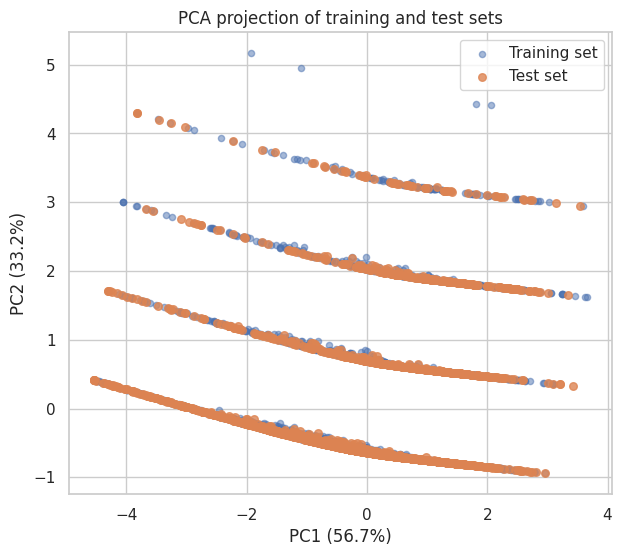

In [ ]:
plt.figure(figsize=(7, 6))

plt.scatter(
    X_train_pca[:, 0], X_train_pca[:, 1],
    alpha=0.5, label='Training set', s=20
)

plt.scatter(
    X_test_pca[:, 0], X_test_pca[:, 1],
    alpha=0.8, label='Test set', s=30
)

plt.xlabel(f'PC1 ({explained_var[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({explained_var[1]*100:.1f}%)')
plt.title('PCA projection of training and test sets')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 6), dpi=300)  # ← 300 dpi

plt.scatter(
    X_train_pca[:, 0], X_train_pca[:, 1],
    alpha=0.5, label='Training set', s=20
)

plt.scatter(
    X_test_pca[:, 0], X_test_pca[:, 1],
    alpha=0.8, label='Test set', s=30
)

plt.xlabel(f'PC1 ({explained_var[0]*100:.1f}%)', fontsize=11)
plt.ylabel(f'PC2 ({explained_var[1]*100:.1f}%)', fontsize=11)
plt.title('PCA projection of training and test sets', fontsize=12)

plt.legend(fontsize=10)
plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)

plt.tight_layout()
plt.show()

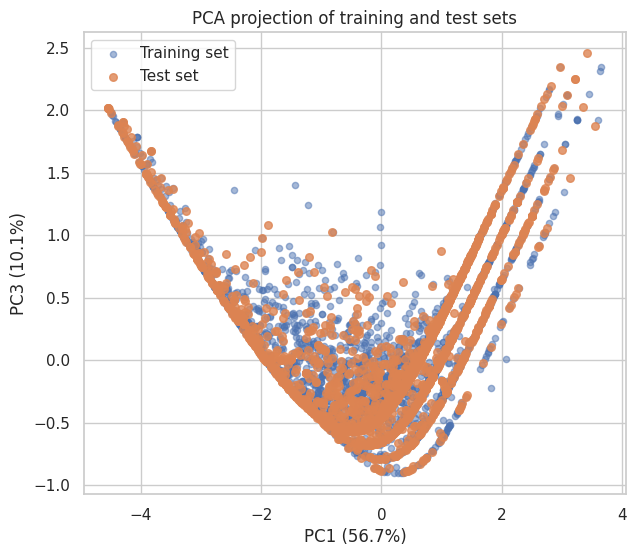

In [ ]:
plt.figure(figsize=(7, 6))

plt.scatter(
    X_train_pca[:, 0], X_train_pca[:, 2],
    alpha=0.5, label='Training set', s=20
)

plt.scatter(
    X_test_pca[:, 0], X_test_pca[:, 2],
    alpha=0.8, label='Test set', s=30
)

plt.xlabel(f'PC1 ({explained_var[0]*100:.1f}%)')
plt.ylabel(f'PC3 ({explained_var[2]*100:.1f}%)')
plt.title('PCA projection of training and test sets')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 6), dpi=300)  # high resolution

plt.scatter(
    X_train_pca[:, 0], X_train_pca[:, 2],  # PC1 vs PC3
    alpha=0.5, label='Training set', s=20
)

plt.scatter(
    X_test_pca[:, 0], X_test_pca[:, 2],
    alpha=0.8, label='Test set', s=30
)

plt.xlabel(f'PC1 ({explained_var[0]*100:.1f}%)', fontsize=11)
plt.ylabel(f'PC3 ({explained_var[2]*100:.1f}%)', fontsize=11)
plt.title('PCA projection of training and test sets', fontsize=12)

plt.legend(fontsize=10)
plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)

plt.tight_layout()
plt.show()

Explained variance ratio:
PC1: 56.70%
PC2: 33.19%
PC3: 10.10%


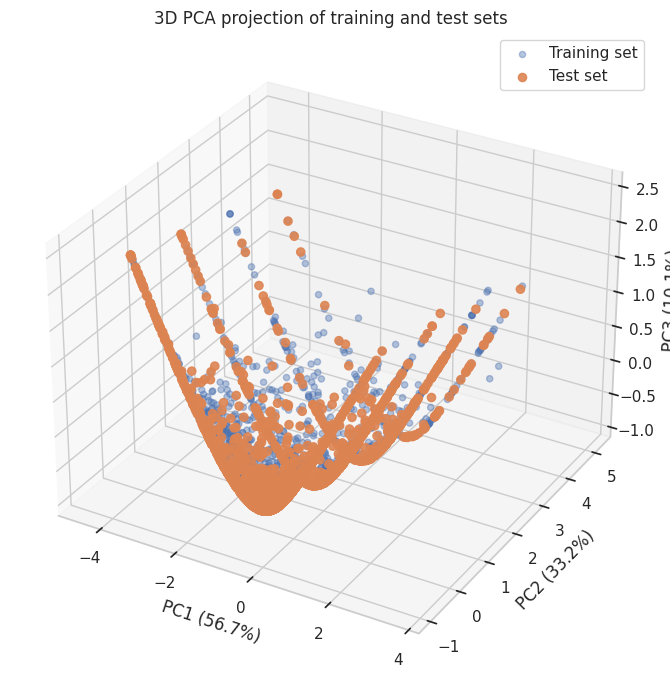

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# ===============================
# PCA WITH 3 COMPONENTS
# ===============================
pca = PCA(n_components=3, random_state=42)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

explained_var = pca.explained_variance_ratio_

print("Explained variance ratio:")
print(f"PC1: {explained_var[0]*100:.2f}%")
print(f"PC2: {explained_var[1]*100:.2f}%")
print(f"PC3: {explained_var[2]*100:.2f}%")

# ===============================
# 3D PCA PLOT
# ===============================
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    X_train_pca[:, 0], X_train_pca[:, 1], X_train_pca[:, 2],
    alpha=0.4, s=20, label='Training set'
)

ax.scatter(
    X_test_pca[:, 0], X_test_pca[:, 1], X_test_pca[:, 2],
    alpha=0.9, s=35, label='Test set'
)

ax.set_xlabel(f'PC1 ({explained_var[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({explained_var[1]*100:.1f}%)')
ax.set_zlabel(f'PC3 ({explained_var[2]*100:.1f}%)')

ax.set_title('3D PCA projection of training and test sets')
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
best_k = 30
best_features = top_features[best_k]

In [ ]:
X_train_30 = X_train[:, best_features]
X_test_30  = X_test[:, best_features]

In [ ]:
sm = SMOTE(k_neighbors=3, random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_30, y_train)

In [ ]:
final_rf = optimize_rf(X_train_res, y_train_res)
final_rf.fit(X_train_res, y_train_res)

RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=1000, random_state=42)

In [ ]:
final_thresh = optimal_threshold(final_rf, X_train_res, y_train_res)
print("Final decision threshold:", final_thresh)

Final decision threshold: 0.909529992256207


In [ ]:
import pickle

bundle = {
    "model": final_rf,
    "features": best_features,
    "scaler": scaler,
    "imputer": imputer,
    "threshold": final_thresh
}

with open("RF_SMOTE_30feat.pkl", "wb") as f:
    pickle.dump(bundle, f)

In [ ]:
import pickle

bundle = {
    "model": final_rf,
    "features": best_features,
    "scaler": scaler,
    "imputer": imputer,
    "threshold": final_thresh
}

with open("RF_SMOTE_30feat.pkl", "wb") as f:
    pickle.dump(bundle, f)

print("Model successfully saved as RF_SMOTE_30feat.pkl")

Model successfully saved as RF_SMOTE_30feat.pkl


In [ ]:
afra_df = pd.read_csv("/content/afra_df_cleaned.csv")

In [ ]:
afra_df

afra_compounds  \
0                                          1,8-cineole   
1                                        1-epi-cubenol   
2                                        1-Octacosanol   
3                                         1-octen-3-ol   
4                  2,4-Dihydroxy-6 methoxyacetophenone   
5                           2-methyl butyl isovalerate   
6    3-(2-(2,5-dihydrofuran-3-yl) ethyl)-2,2-Dimeth...   
7                                          3-thujanone   
8                            4-O-Methylglucuronic acid   
9                                          4-terpineol   
10                                           Arabinose   
11                                        ar-curcumene   
12                                        Arteannuin P   
13                                        Arteannuin S   
14                                        Arteannuin T   
15                                             Artemin   
16                                           artemisal   
17                                   artemisia alcohol   
18                                    artemisia ketone   
19                                   artemisyl acetate   
20                                             Artesin   
21                                          ascaridole   
22                                             azulene   
23                                      bicycloelemene   
24                                   bicyclogermacrene   
25                                             borneol   
26                                      bornyl acetate   
27                                        Cadinanolide   
28                                          calamenene   
29                                            camphene   
30                                             camphor   
31                  caryophylla-2(12),6(13)-dien-5-one   
32                                caryophylladienol-II   
33                                 caryophyllene oxide   
34                                         chamazulene   
35                                      chrysanthenone   
36                              Chrysoeriol rutinoside   
37                                         cis-carveol   
38                                   cis-chrysanthenol   
39                           cis-chrysanthenyl acetate   
40                                    Cis-melilotoside   
41                                       cis-piperitol   
42                               cis-p-menth-2-en-1-ol   
43                      cis-p-mentha-1-(7),8-dien-2-ol   
44                                cis-sabinene hydrate   
45                                        cis-verbenol   
46                                             cubebol   
47                                       cumin alcohol   
48                                       cuminaldehyde   
49                                            davanone   
50                                 dehydro-1,8-cineole   
51                                 dehydrosabinaketone   
52                                         epi-cubebol   
53                                              Fucose   
54                                           Galactose   
55                                   Galacturonic acid   
56                                            geraniol   
57                                          germacrene   
58                                        germacrene D   
59                                   germacrene D-4-ol   
60                                            globulol   
61                                             Glucose   
62                                     Glucuronic acid   
63                                     Homoeriodictyol   
64                                         intermedeol   
65                                         intermediol   
66                                 isoamyl isovalerate   
67                                     Isoarteannuin A   
68                                    

In [ ]:
afra_df.shape

(154, 3)

In [ ]:
afra_df.isna().sum()

afra_compounds       0
canonical_smiles     0
mol                 34
dtype: int64

In [ ]:
afra_df = afra_df.dropna()

In [ ]:
afra_df

afra_compounds  \
0                            1,8-cineole   
1                          1-epi-cubenol   
2                          1-Octacosanol   
3                           1-octen-3-ol   
4    2,4-Dihydroxy-6 methoxyacetophenone   
5             2-methyl butyl isovalerate   
7                            3-thujanone   
8              4-O-Methylglucuronic acid   
9                            4-terpineol   
10                             Arabinose   
11                          ar-curcumene   
12                          Arteannuin P   
13                          Arteannuin S   
14                          Arteannuin T   
15                               Artemin   
16                             artemisal   
17                     artemisia alcohol   
18                      artemisia ketone   
19                     artemisyl acetate   
20                               Artesin   
21                            ascaridole   
22                               azulene   
23                        bicycloelemene   
24                     bicyclogermacrene   
25                               borneol   
26                        bornyl acetate   
28                            calamenene   
29                              camphene   
30                               camphor   
31    caryophylla-2(12),6(13)-dien-5-one   
32                  caryophylladienol-II   
33                   caryophyllene oxide   
34                           chamazulene   
35                        chrysanthenone   
36                Chrysoeriol rutinoside   
37                           cis-carveol   
38                     cis-chrysanthenol   
39             cis-chrysanthenyl acetate   
40                      Cis-melilotoside   
41                         cis-piperitol   
42                 cis-p-menth-2-en-1-ol   
43        cis-p-mentha-1-(7),8-dien-2-ol   
44                  cis-sabinene hydrate   
45                          cis-verbenol   
46                               cubebol   
47                         cumin alcohol   
48                         cuminaldehyde   
49                              davanone   
50                   dehydro-1,8-cineole   
51                   dehydrosabinaketone   
52                           epi-cubebol   
53                                Fucose   
54                             Galactose   
55                     Galacturonic acid   
56                              geraniol   
57                            germacrene   
58                          germacrene D   
59                     germacrene D-4-ol   
60                              globulol   
61                               Glucose   
62                       Glucuronic acid   
63                       Homoeriodictyol   
64                           intermedeol   
66                   isoamyl isovalerate   
68                         Isononadecano   
69             isopropyl-3-methylbenzene   
70                            lavandulol   
71                              limonene   
72                              linalool   
73                      linalool acetate   
74                               Mannose   
75                             Maritimin   
76                     methyl linolenate   
77                               myrcene   
78                              myrtenal   
79                              myrtenol   
80                           octadecanol   
81                          p-cymen-8-ol   
82                              p-cymene   
83                         pentylbenzene   
84                 p-Hydroxyacetophenone   
85                           pinocarvone   
86                             piperitol   
87                            piperitone   
88                    p-isopropyl phenol   
89                p-mentha-1,4-dien-7-ol   
90               p-mentha-1,8-dien-10-ol   
91                        p-menthatriene   
96                           Quinic acid   
97                              Reynosin   
98                    

In [ ]:
# Convert SMILES to Mol objects
afra_df['mol'] = afra_df['canonical_smiles'].apply(Chem.MolFromSmiles)

In [ ]:
calc = Calculator(descriptors, ignore_3D=True)  # ignore 3D descriptors

In [ ]:
# feature calculation
X = calc.pandas(afra_df['mol'])

100%|██████████| 120/120 [00:46<00:00,  2.57it/s]


In [ ]:
afra_df['morgan_fp'] = afra_df['mol'].apply(
    lambda x: AllChem.GetMorganFingerprintAsBitVect(x, radius=2, nBits=2048)
)

[22:02:29] DEPRECATION WARNING: please use MorganGenerator
[22:02:29] DEPRECATION WARNING: please use MorganGenerator
[22:02:29] DEPRECATION WARNING: please use MorganGenerator
[22:02:29] DEPRECATION WARNING: please use MorganGenerator
[22:02:29] DEPRECATION WARNING: please use MorganGenerator
[22:02:29] DEPRECATION WARNING: please use MorganGenerator
[22:02:29] DEPRECATION WARNING: please use MorganGenerator
[22:02:29] DEPRECATION WARNING: please use MorganGenerator
[22:02:29] DEPRECATION WARNING: please use MorganGenerator
[22:02:29] DEPRECATION WARNING: please use MorganGenerator
[22:02:29] DEPRECATION WARNING: please use MorganGenerator
[22:02:29] DEPRECATION WARNING: please use MorganGenerator
[22:02:29] DEPRECATION WARNING: please use MorganGenerator
[22:02:29] DEPRECATION WARNING: please use MorganGenerator
[22:02:29] DEPRECATION WARNING: please use MorganGenerator
[22:02:29] DEPRECATION WARNING: please use MorganGenerator
[22:02:29] DEPRECATION WARNING: please use MorganGenerat

In [ ]:
afra_df.head()

afra_compounds                canonical_smiles  \
0                          1,8-cineole           CC1(C2CCC(O1)(CC2)C)C   
1                        1-epi-cubenol  CC1CCC(C2C1(CCC(=C2)C)O)C(C)C    
2                        1-Octacosanol   CCCCCCCCCCCCCCCCCCCCCCCCCCCCO   
3                         1-octen-3-ol                    CCCCCC(C=C)O   
4  2,4-Dihydroxy-6 methoxyacetophenone     CC(=O)C1=C(C=C(C=C1OC)O)O     

                                                mol  \
0  <rdkit.Chem.rdchem.Mol object at 0x7a30999a14d0>   
1  <rdkit.Chem.rdchem.Mol object at 0x7a30529afc30>   
2  <rdkit.Chem.rdchem.Mol object at 0x7a309a25c660>   
3  <rdkit.Chem.rdchem.Mol object at 0x7a309a25c6d0>   
4  <rdkit.Chem.rdchem.Mol object at 0x7a309a25c0b0>   

                                           morgan_fp  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

In [ ]:
X_afra = afra_df.apply(pd.to_numeric, errors='coerce').values
X_afra = np.where(np.isfinite(X_afra), X_afra, np.nan)

X_afra_imp = imputer.transform(X_afra)
X_afra_scaled = scaler.transform(X_afra_imp)

X_afra_30 = X_afra_scaled[:, best_features]

ValueError: X has 4 features, but SimpleImputer is expecting 6 features as input.

In [ ]:
train_descriptor_cols = df.drop(columns=["Class"]).columns
print(len(train_descriptor_cols))
print(train_descriptor_cols)

6
Index(['canonical_smiles', 'standard_value', 'pchembl_value', 'mol',
       'morgan_fp', 'ro5_violations'],
      dtype='object')


In [ ]:
afra_df_aligned = afra_df[train_descriptor_cols]

KeyError: "['standard_value', 'pchembl_value', 'ro5_violations'] not in index"

In [ ]:
import numpy as np
import pandas as pd

# Expand Morgan fingerprints into columns
X_fp = np.array([list(fp) for fp in df['morgan_fp']])

fp_cols = [f"FP_{i}" for i in range(X_fp.shape[1])]
df_fp = pd.DataFrame(X_fp, columns=fp_cols)

# Final ML dataframe
df_ml = pd.concat([df_fp, df['Class']], axis=1)

print(df_ml.shape)

(8771, 2049)


In [ ]:
X_afra_fp = np.array([list(fp) for fp in afra_df['morgan_fp']])
afra_fp_df = pd.DataFrame(X_afra_fp, columns=fp_cols)

In [ ]:
afra_df_aligned = afra_fp_df[fp_cols]

In [ ]:
print(df_fp.shape)
print(afra_fp_df.shape)

(8771, 2048)
(120, 2048)


In [ ]:
len(df['morgan_fp'].iloc[0])

2048

In [ ]:
import pickle

with open("RF_SMOTE_30feat.pkl", "rb") as f:
    bundle = pickle.load(f)

model = bundle["model"]
features = bundle["features"]
scaler = bundle["scaler"]
imputer = bundle["imputer"]
threshold = bundle["threshold"]

In [ ]:
X_afra = afra_fp_df.values   # FP_0 ... FP_2047

X_afra = np.where(np.isfinite(X_afra), X_afra, np.nan)
X_afra_imp = imputer.transform(X_afra)
X_afra_scaled = scaler.transform(X_afra_imp)

X_afra_sel = X_afra_scaled[:, features]

ValueError: X has 2048 features, but SimpleImputer is expecting 6 features as input.

In [ ]:
# X and y from expanded fingerprints
X = df_fp.values          # shape: (n_samples, 2048)
y = df['Class'].values


In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import numpy as np

X = np.where(np.isfinite(X), X, np.nan)

imputer = SimpleImputer(strategy="most_frequent")
X_imp = imputer.fit_transform(X)

scaler = StandardScaler(with_mean=False)  # IMPORTANT for sparse/binary FP
X_scaled = scaler.fit_transform(X_imp)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, stratify=y, random_state=42
)

In [ ]:
from sklearn.feature_selection import mutual_info_classif
import numpy as np

mi = mutual_info_classif(X_train, y_train, random_state=42)
best_features = np.argsort(mi)[-30:]


In [ ]:
from imblearn.over_sampling import SMOTE

X_train_30 = X_train[:, best_features]

sm = SMOTE(k_neighbors=3, random_state=42)
X_res, y_res = sm.fit_resample(X_train_30, y_train)

final_rf = optimize_rf(X_res, y_res)
final_rf.fit(X_res, y_res)

RandomForestClassifier(max_depth=40, n_estimators=600, random_state=42)

In [ ]:
final_thresh = optimal_threshold(final_rf, X_res, y_res)

In [ ]:
import pickle

bundle = {
    "model": final_rf,
    "features": best_features,
    "scaler": scaler,
    "imputer": imputer,
    "threshold": final_thresh
}

with open("RF_SMOTE_30feat.pkl", "wb") as f:
    pickle.dump(bundle, f)

print("Updated model saved correctly.")

Updated model saved correctly.


In [ ]:
X_afra = afra_fp_df.values
X_afra = np.where(np.isfinite(X_afra), X_afra, np.nan)

X_afra_imp = imputer.transform(X_afra)
X_afra_scaled = scaler.transform(X_afra_imp)

X_afra_sel = X_afra_scaled[:, best_features]


In [ ]:
afra_probs = final_rf.predict_proba(X_afra_sel)[:, 1]

In [ ]:
afra_pred = (afra_probs >= final_thresh).astype(int)

In [ ]:
afra_results = afra_df.copy()
afra_results["Predicted_Probability"] = afra_probs
afra_results["Predicted_Class"] = afra_pred

In [ ]:
afra_results.to_csv("afra_results.csv", index=False)

In [ ]:
afra_results

afra_compounds  \
0                            1,8-cineole   
1                          1-epi-cubenol   
2                          1-Octacosanol   
3                           1-octen-3-ol   
4    2,4-Dihydroxy-6 methoxyacetophenone   
5             2-methyl butyl isovalerate   
7                            3-thujanone   
8              4-O-Methylglucuronic acid   
9                            4-terpineol   
10                             Arabinose   
11                          ar-curcumene   
12                          Arteannuin P   
13                          Arteannuin S   
14                          Arteannuin T   
15                               Artemin   
16                             artemisal   
17                     artemisia alcohol   
18                      artemisia ketone   
19                     artemisyl acetate   
20                               Artesin   
21                            ascaridole   
22                               azulene   
23                        bicycloelemene   
24                     bicyclogermacrene   
25                               borneol   
26                        bornyl acetate   
28                            calamenene   
29                              camphene   
30                               camphor   
31    caryophylla-2(12),6(13)-dien-5-one   
32                  caryophylladienol-II   
33                   caryophyllene oxide   
34                           chamazulene   
35                        chrysanthenone   
36                Chrysoeriol rutinoside   
37                           cis-carveol   
38                     cis-chrysanthenol   
39             cis-chrysanthenyl acetate   
40                      Cis-melilotoside   
41                         cis-piperitol   
42                 cis-p-menth-2-en-1-ol   
43        cis-p-mentha-1-(7),8-dien-2-ol   
44                  cis-sabinene hydrate   
45                          cis-verbenol   
46                               cubebol   
47                         cumin alcohol   
48                         cuminaldehyde   
49                              davanone   
50                   dehydro-1,8-cineole   
51                   dehydrosabinaketone   
52                           epi-cubebol   
53                                Fucose   
54                             Galactose   
55                     Galacturonic acid   
56                              geraniol   
57                            germacrene   
58                          germacrene D   
59                     germacrene D-4-ol   
60                              globulol   
61                               Glucose   
62                       Glucuronic acid   
63                       Homoeriodictyol   
64                           intermedeol   
66                   isoamyl isovalerate   
68                         Isononadecano   
69             isopropyl-3-methylbenzene   
70                            lavandulol   
71                              limonene   
72                              linalool   
73                      linalool acetate   
74                               Mannose   
75                             Maritimin   
76                     methyl linolenate   
77                               myrcene   
78                              myrtenal   
79                              myrtenol   
80                           octadecanol   
81                          p-cymen-8-ol   
82                              p-cymene   
83                         pentylbenzene   
84                 p-Hydroxyacetophenone   
85                           pinocarvone   
86                             piperitol   
87                            piperitone   
88                    p-isopropyl phenol   
89                p-mentha-1,4-dien-7-ol   
90               p-mentha-1,8-dien-10-ol   
91                        p-menthatriene   
96                           Quinic acid   
97                              Reynosin   
98                    

In [ ]:
afra_actives = afra_results[afra_results["Predicted_Class"] == 1]

In [ ]:
afra_actives

afra_compounds  \
0                            1,8-cineole   
1                          1-epi-cubenol   
2                          1-Octacosanol   
3                           1-octen-3-ol   
4    2,4-Dihydroxy-6 methoxyacetophenone   
5             2-methyl butyl isovalerate   
7                            3-thujanone   
8              4-O-Methylglucuronic acid   
9                            4-terpineol   
10                             Arabinose   
11                          ar-curcumene   
12                          Arteannuin P   
14                          Arteannuin T   
15                               Artemin   
16                             artemisal   
17                     artemisia alcohol   
18                      artemisia ketone   
19                     artemisyl acetate   
20                               Artesin   
21                            ascaridole   
22                               azulene   
23                        bicycloelemene   
24                     bicyclogermacrene   
25                               borneol   
26                        bornyl acetate   
28                            calamenene   
29                              camphene   
30                               camphor   
31    caryophylla-2(12),6(13)-dien-5-one   
32                  caryophylladienol-II   
34                           chamazulene   
35                        chrysanthenone   
36                Chrysoeriol rutinoside   
37                           cis-carveol   
38                     cis-chrysanthenol   
39             cis-chrysanthenyl acetate   
40                      Cis-melilotoside   
41                         cis-piperitol   
42                 cis-p-menth-2-en-1-ol   
43        cis-p-mentha-1-(7),8-dien-2-ol   
44                  cis-sabinene hydrate   
45                          cis-verbenol   
46                               cubebol   
47                         cumin alcohol   
48                         cuminaldehyde   
49                              davanone   
50                   dehydro-1,8-cineole   
51                   dehydrosabinaketone   
52                           epi-cubebol   
53                                Fucose   
54                             Galactose   
55                     Galacturonic acid   
56                              geraniol   
57                            germacrene   
58                          germacrene D   
59                     germacrene D-4-ol   
60                              globulol   
61                               Glucose   
62                       Glucuronic acid   
63                       Homoeriodictyol   
64                           intermedeol   
66                   isoamyl isovalerate   
68                         Isononadecano   
69             isopropyl-3-methylbenzene   
70                            lavandulol   
71                              limonene   
72                              linalool   
73                      linalool acetate   
74                               Mannose   
75                             Maritimin   
76                     methyl linolenate   
77                               myrcene   
78                              myrtenal   
79                              myrtenol   
80                           octadecanol   
81                          p-cymen-8-ol   
82                              p-cymene   
83                         pentylbenzene   
84                 p-Hydroxyacetophenone   
85                           pinocarvone   
86                             piperitol   
87                            piperitone   
88                    p-isopropyl phenol   
89                p-mentha-1,4-dien-7-ol   
90               p-mentha-1,8-dien-10-ol   
91                        p-menthatriene   
96                           Quinic acid   
97                              Reynosin   
98                              Rhamnose   
99                       Rosmarinic acid   
100                   

In [ ]:
afra_actives.to_csv("afra_actives.csv", index=False)

In [ ]:
top_afra = afra_actives.sort_values(
    by="Predicted_Probability", ascending=False
)

In [ ]:
top_afra.to_csv("top_afra_asecending.csv", index=False)

In [ ]:
top_afra.head(15)

afra_compounds                                canonical_smiles  \
62      Glucuronic acid   [C@@H]1([C@@H]([C@H](OC([C@@H]1O)O)C(=O)O)O)O   
53               Fucose        C[C@H]1[C@H]([C@H]([C@@H](C(O1)O)O)O)O     
55    Galacturonic acid  C(=O)[C@@H]([C@H]([C@H]([C@@H](C(=O)O)O)O)O)O    
56             geraniol                            CC(=CCC/C(=C/CO)/C)C   
61              Glucose    C([C@@H]1[C@H]([C@@H]([C@H](C(O1)O)O)O)O)O     
66  isoamyl isovalerate                           CC(C)CCOC(=O)CC(C)C     
68        Isononadecano                 CC(C)CCCCCCCCCCCCCCCC(=O)[O-]     
70           lavandulol                      CC(=CC[C@@H](CO)C(=C)C)C     
72             linalool                             CC(=CCCC(C)(C=C)O)C   
73     linalool acetate                     CC(=CCCC(C)(C=C)OC(=O)C)C     
74              Mannose   C([C@@H]1[C@H]([C@@H]([C@@H](C(O1)O)O)O)O)O     
19    artemisyl acetate                     CC(=CC(C(C)(C)C=C)OC(=O)C)C   
18     artemisia ketone                         CC(=CC(=O)C(C)(C)C=C)C    
17    artemisia alcohol                     CC(=CC(C(C)(C)C=C)OC(=O)C)C   
76    methyl linolenate               CC/C=C\C/C=C\C/C=C\CCCCCCCC(=O)OC   

                                                 mol  \
62  <rdkit.Chem.rdchem.Mol object at 0x7a309a25d9a0>   
53  <rdkit.Chem.rdchem.Mol object at 0x7a309a25d5b0>   
55  <rdkit.Chem.rdchem.Mol object at 0x7a309a25d690>   
56  <rdkit.Chem.rdchem.Mol object at 0x7a309a25d700>   
61  <rdkit.Chem.rdchem.Mol object at 0x7a309a25d930>   
66  <rdkit.Chem.rdchem.Mol object at 0x7a309a25daf0>   
68  <rdkit.Chem.rdchem.Mol object at 0x7a309a25db60>   
70  <rdkit.Chem.rdchem.Mol object at 0x7a309a25dc40>   
72  <rdkit.Chem.rdchem.Mol object at 0x7a309a25dd20>   
73  <rdkit.Chem.rdchem.Mol object at 0x7a309a25dd90>   
74  <rdkit.Chem.rdchem.Mol object at 0x7a309a25de00>   
19  <rdkit.Chem.rdchem.Mol object at 0x7a309a25c430>   
18  <rdkit.Chem.rdchem.Mol object at 0x7a309a25c3c0>   
17  <rdkit.Chem.rdchem.Mol object at 0x7a309a25c900>   
76  <rdkit.Chem.rdchem.Mol object at 0x7a309a25dee0>   

                                            morgan_fp  Predicted_Probability  \
62  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...                    1.0   
53  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...                    1.0   
55  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...                    1.0   
56  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...                    1.0   
61  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...                    1.0   
66  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...                    1.0   
68  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...                    1.0   
70  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...                    1.0   
72  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...                    1.0   
73  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...                    1.0   
74  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...                    1.0   
19  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...                    1.0   
18  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...                    1.0   
17  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...                    1.0   
76  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...                    1.0   

    Predicted_Class  
62                1  
53                1  
55                1  
56                1  
61                1  
66                1  
68                1  
70                1  
72                1  
73                1  
74                1  
19                1  
18                1  
17                1  
76                1

In [ ]:
# Assuming 'afra_results' has columns: 'Predicted_Class' and 'Predicted_Probability'

# Filter predicted actives
afra_actives = afra_results[afra_results["Predicted_Class"] == 1]

# Sort by predicted probability in descending order
top_afra = afra_actives.sort_values(by="Predicted_Probability", ascending=False)

# Optional: select only those with probability exactly 1
top_afra_prob1 = top_afra[top_afra["Predicted_Probability"] == 1]

# Display top 10 highest probability actives
print(top_afra_prob1.head(10))

         afra_compounds                                canonical_smiles  \
62      Glucuronic acid   [C@@H]1([C@@H]([C@H](OC([C@@H]1O)O)C(=O)O)O)O   
53               Fucose        C[C@H]1[C@H]([C@H]([C@@H](C(O1)O)O)O)O     
55    Galacturonic acid  C(=O)[C@@H]([C@H]([C@H]([C@@H](C(=O)O)O)O)O)O    
56             geraniol                            CC(=CCC/C(=C/CO)/C)C   
61              Glucose    C([C@@H]1[C@H]([C@@H]([C@H](C(O1)O)O)O)O)O     
66  isoamyl isovalerate                           CC(C)CCOC(=O)CC(C)C     
68        Isononadecano                 CC(C)CCCCCCCCCCCCCCCC(=O)[O-]     
70           lavandulol                      CC(=CC[C@@H](CO)C(=C)C)C     
72             linalool                             CC(=CCCC(C)(C=C)O)C   
73     linalool acetate                     CC(=CCCC(C)(C=C)OC(=O)C)C     

                                                 mol  \
62  <rdkit.Chem.rdchem.Mol object at 0x7a309a25d9a0>   
53  <rdkit.Chem.rdchem.Mol object at 0x7a309a25d5b0>   
55  <r

In [ ]:
top_afra_prob1.shape

(28, 6)

In [ ]:
top_afra_prob1.to_csv("top_afra_prob1.csv", index=False)

In [ ]:
pca_3d = PCA(n_components=3, random_state=42)

X_train_pca3 = pca_3d.fit_transform(X_train)
X_test_pca3  = pca_3d.transform(X_test)

X_afra_act_pca3 = pca_3d.transform(
    X_afra_scaled[afra_pred == 1]
)

In [ ]:
print("Number of predicted actives:", sum(afra_pred))


Number of predicted actives: 117


In [ ]:
print("Number of predicted actives:", len(afra_actives))


Number of predicted actives: 117


In [ ]:
# Get indices of predicted actives
actives_mask = afra_results["Predicted_Class"] == 1

# Transform into PCA space
X_afra_act_pca3 = pca_3d.transform(X_afra_scaled[actives_mask])
print("Shape of active PCA coords:", X_afra_act_pca3.shape)


Shape of active PCA coords: (117, 3)


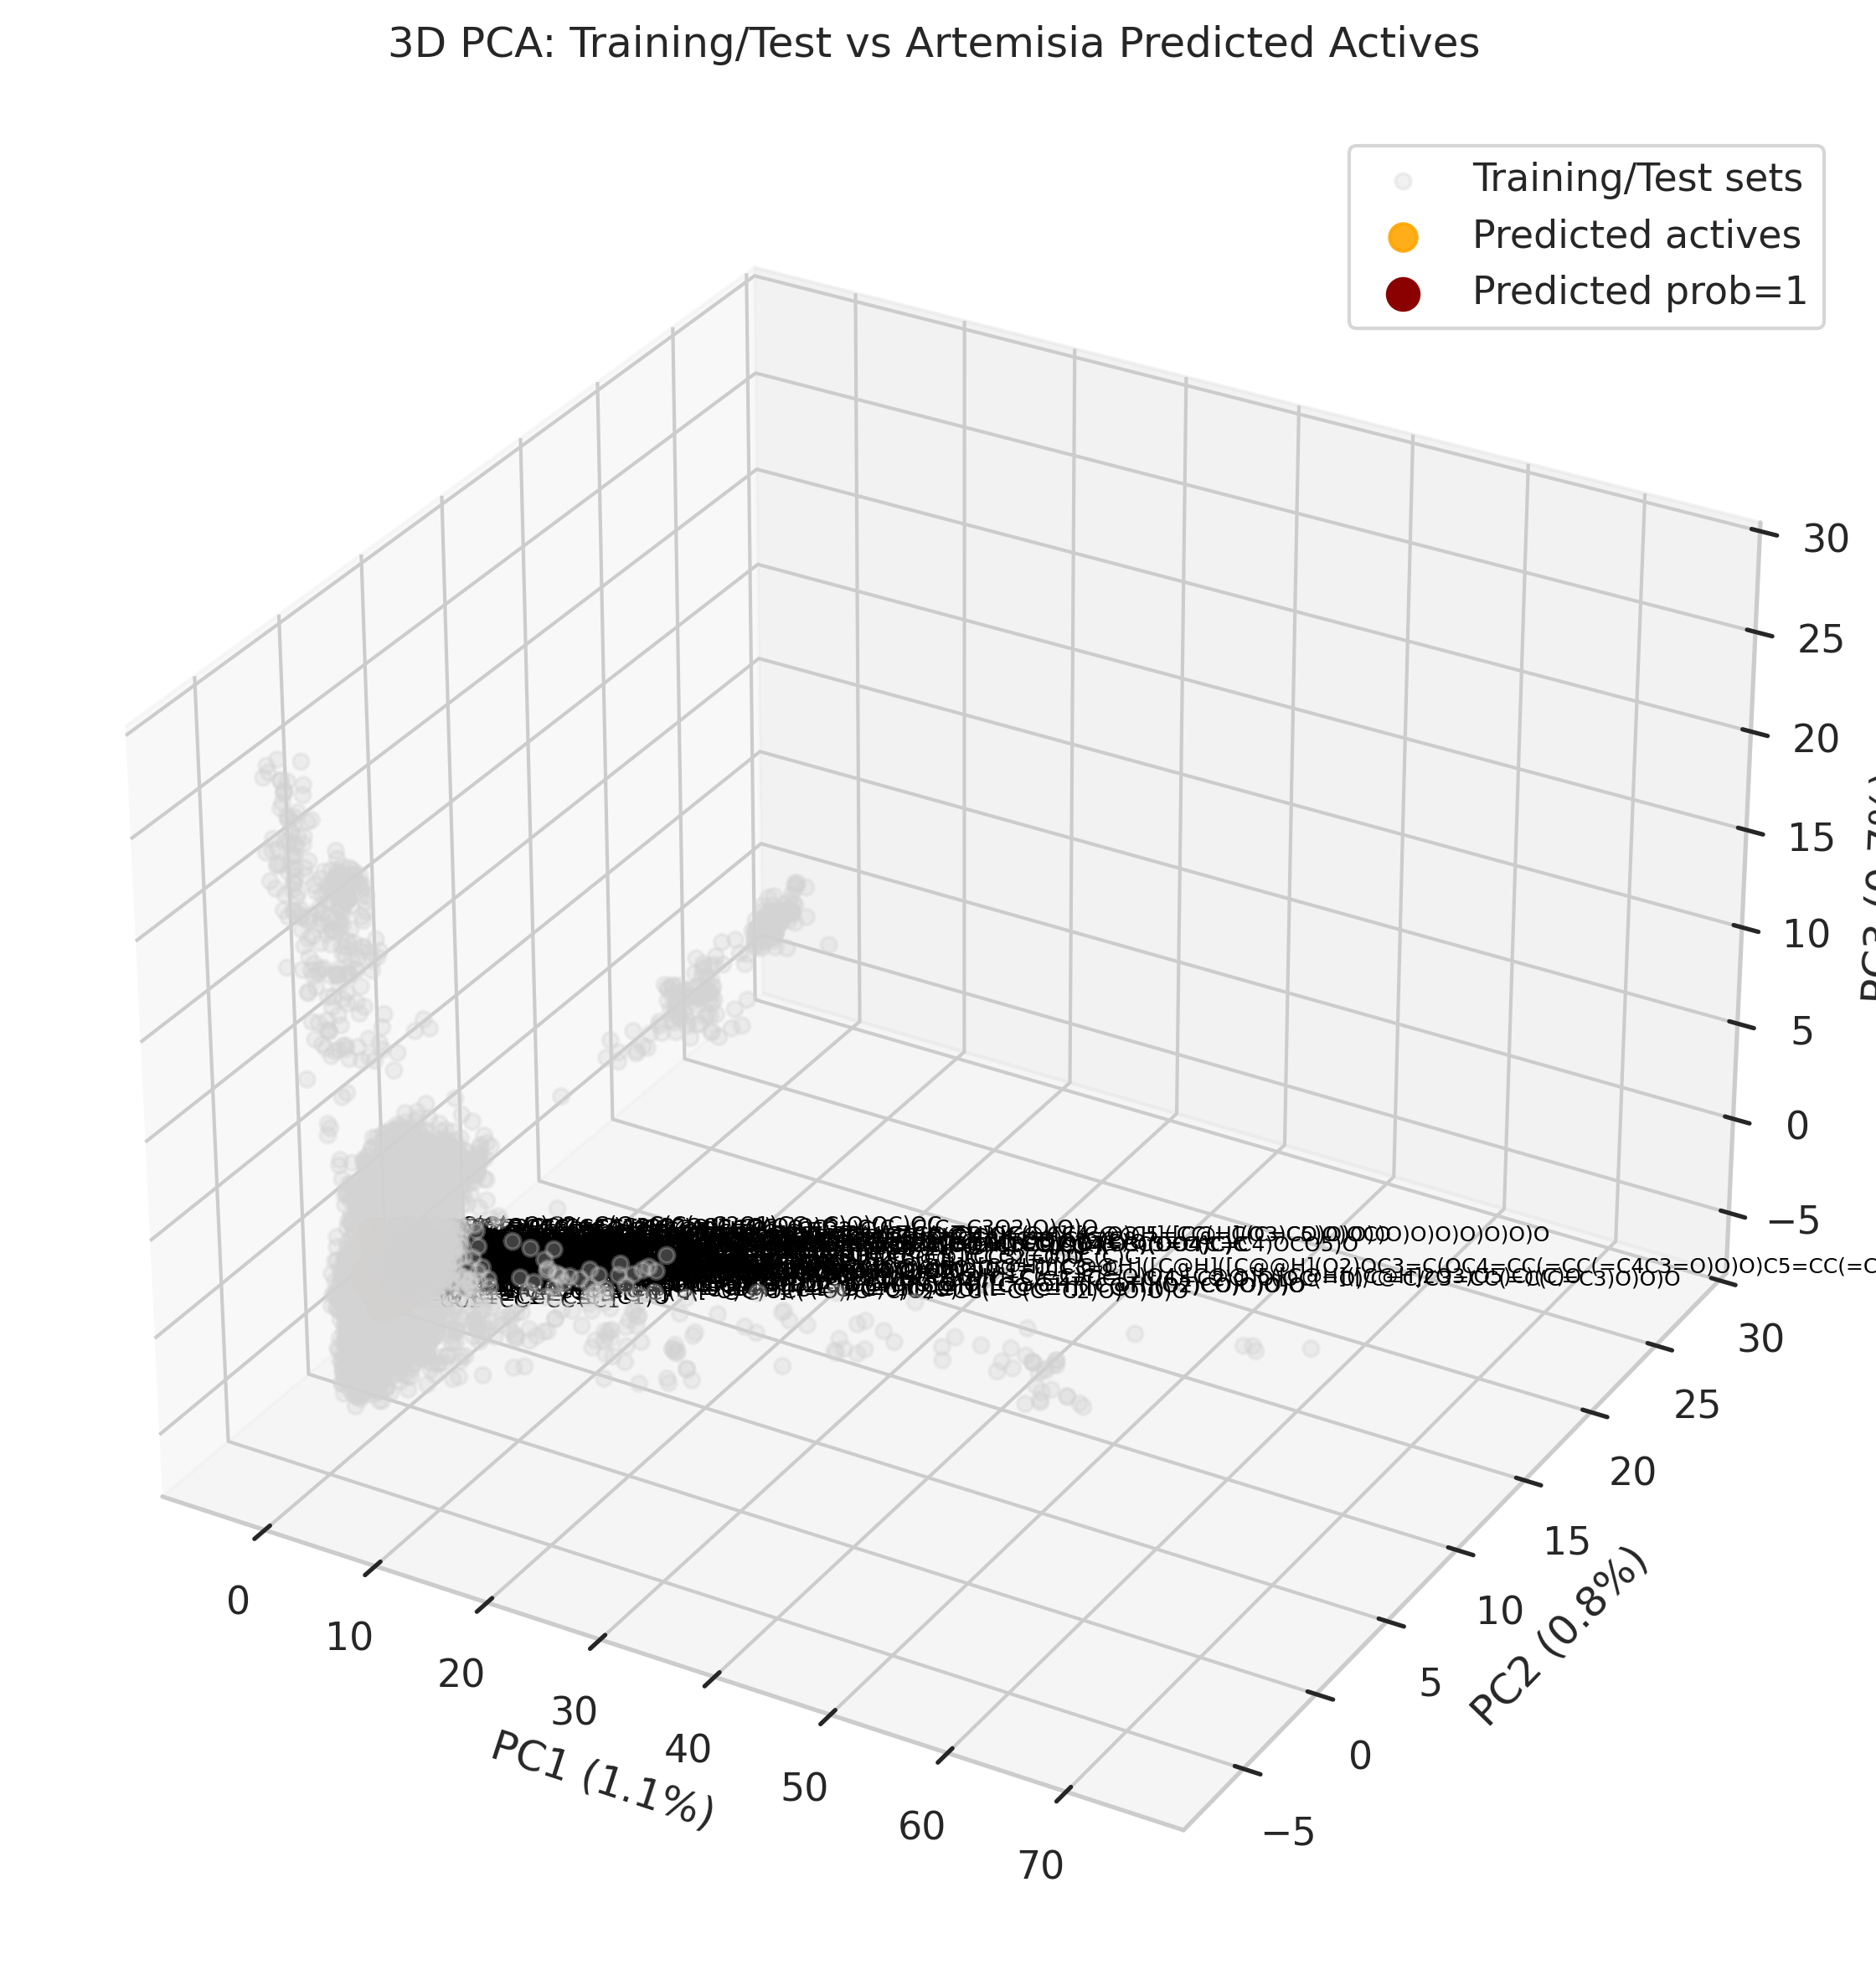

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --------------------------
# 3D PCA Plot with all actives annotated
# --------------------------
fig = plt.figure(figsize=(10, 8), dpi=300)
ax = fig.add_subplot(111, projection='3d')

# Training + Test sets: faint gray
ax.scatter(
    X_train_pca3[:,0], X_train_pca3[:,1], X_train_pca3[:,2],
    c='lightgray', alpha=0.3, s=20, label='Training/Test sets'
)
ax.scatter(
    X_test_pca3[:,0], X_test_pca3[:,1], X_test_pca3[:,2],
    c='lightgray', alpha=0.3, s=20
)

# Predicted Artemisia actives: orange
ax.scatter(
    X_afra_actives[:,0], X_afra_actives[:,1], X_afra_actives[:,2],
    c='orange', alpha=0.9, s=60, label='Predicted actives'
)

# Predicted probability=1 actives: dark red
ax.scatter(
    X_afra_prob1[:,0], X_afra_prob1[:,1], X_afra_prob1[:,2],
    c='darkred', alpha=1.0, s=80, label='Predicted prob=1'
)

# Annotate ALL predicted actives (orange + dark red)
for i, smi in enumerate(afra_actives["canonical_smiles"]):
    coords = X_afra_actives[i]
    ax.text(coords[0], coords[1], coords[2], smi, fontsize=6, color='black')

# Axis labels with explained variance
ax.set_xlabel(f'PC1 ({explained_var[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({explained_var[1]*100:.1f}%)')
ax.set_zlabel(f'PC3 ({explained_var[2]*100:.1f}%)')

ax.set_title('3D PCA: Training/Test vs Artemisia Predicted Actives', pad=20)
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()


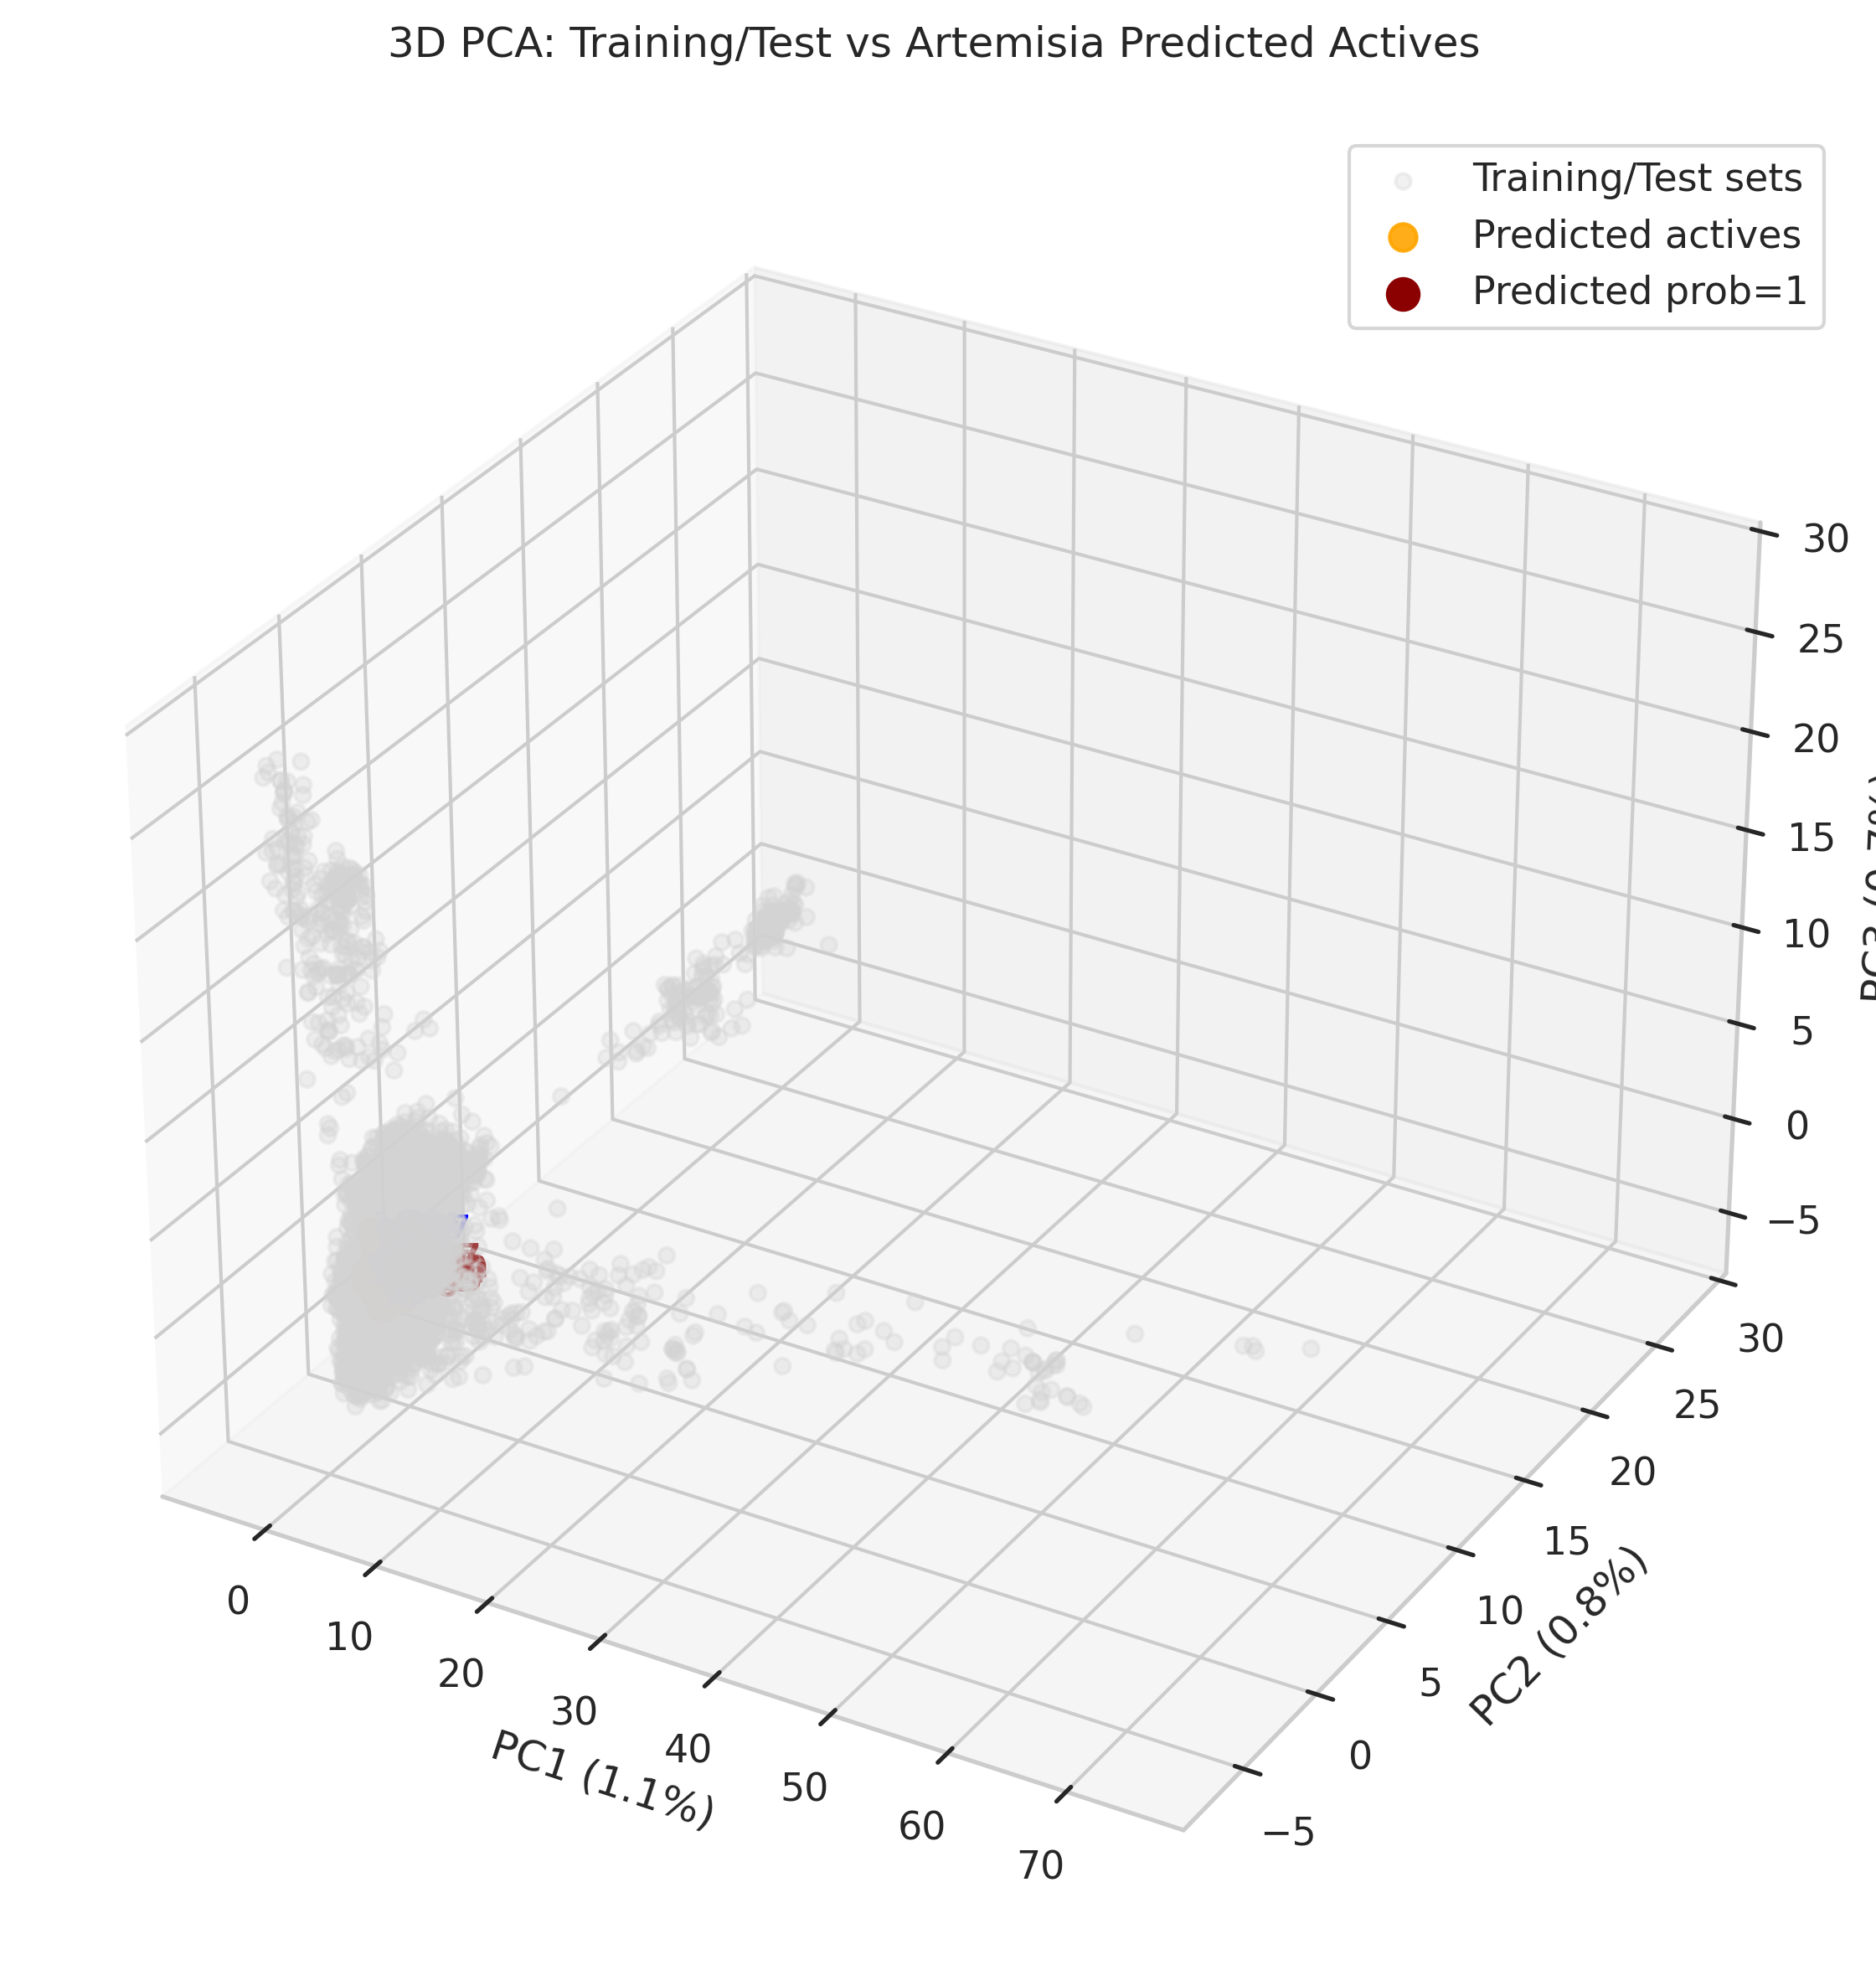

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --------------------------
# 3D PCA Plot with numbered actives and highlighted prob=1 actives
# --------------------------
fig = plt.figure(figsize=(10, 8), dpi=300)
ax = fig.add_subplot(111, projection='3d')

# Training + Test sets: faint gray
ax.scatter(
    X_train_pca3[:,0], X_train_pca3[:,1], X_train_pca3[:,2],
    c='lightgray', alpha=0.3, s=20, label='Training/Test sets'
)
ax.scatter(
    X_test_pca3[:,0], X_test_pca3[:,1], X_test_pca3[:,2],
    c='lightgray', alpha=0.3, s=20
)

# Predicted Artemisia actives: orange
ax.scatter(
    X_afra_actives[:,0], X_afra_actives[:,1], X_afra_actives[:,2],
    c='orange', alpha=0.9, s=60, label='Predicted actives'
)

# Predicted probability=1 actives: dark red
ax.scatter(
    X_afra_prob1[:,0], X_afra_prob1[:,1], X_afra_prob1[:,2],
    c='darkred', alpha=1.0, s=80, label='Predicted prob=1'
)

# Annotate predicted actives with numbers (orange)
for i in range(X_afra_actives.shape[0]):
    coords = X_afra_actives[i]
    ax.text(coords[0]+0.01, coords[1]+0.01, coords[2]+0.01,  # small offset to avoid overlap
            str(i+1), fontsize=8, fontweight='bold', color='blue')

# Annotate prob=1 actives differently (dark red)
for i in range(X_afra_prob1.shape[0]):
    coords = X_afra_prob1[i]
    ax.text(coords[0]+0.01, coords[1]+0.01, coords[2]+0.01,
            f"P{i+1}", fontsize=10, fontweight='bold', color='darkred')

# Axis labels with explained variance
ax.set_xlabel(f'PC1 ({explained_var[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({explained_var[1]*100:.1f}%)')
ax.set_zlabel(f'PC3 ({explained_var[2]*100:.1f}%)')

# Title and legend
ax.set_title('3D PCA: Training/Test vs Artemisia Predicted Actives', pad=20)
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()


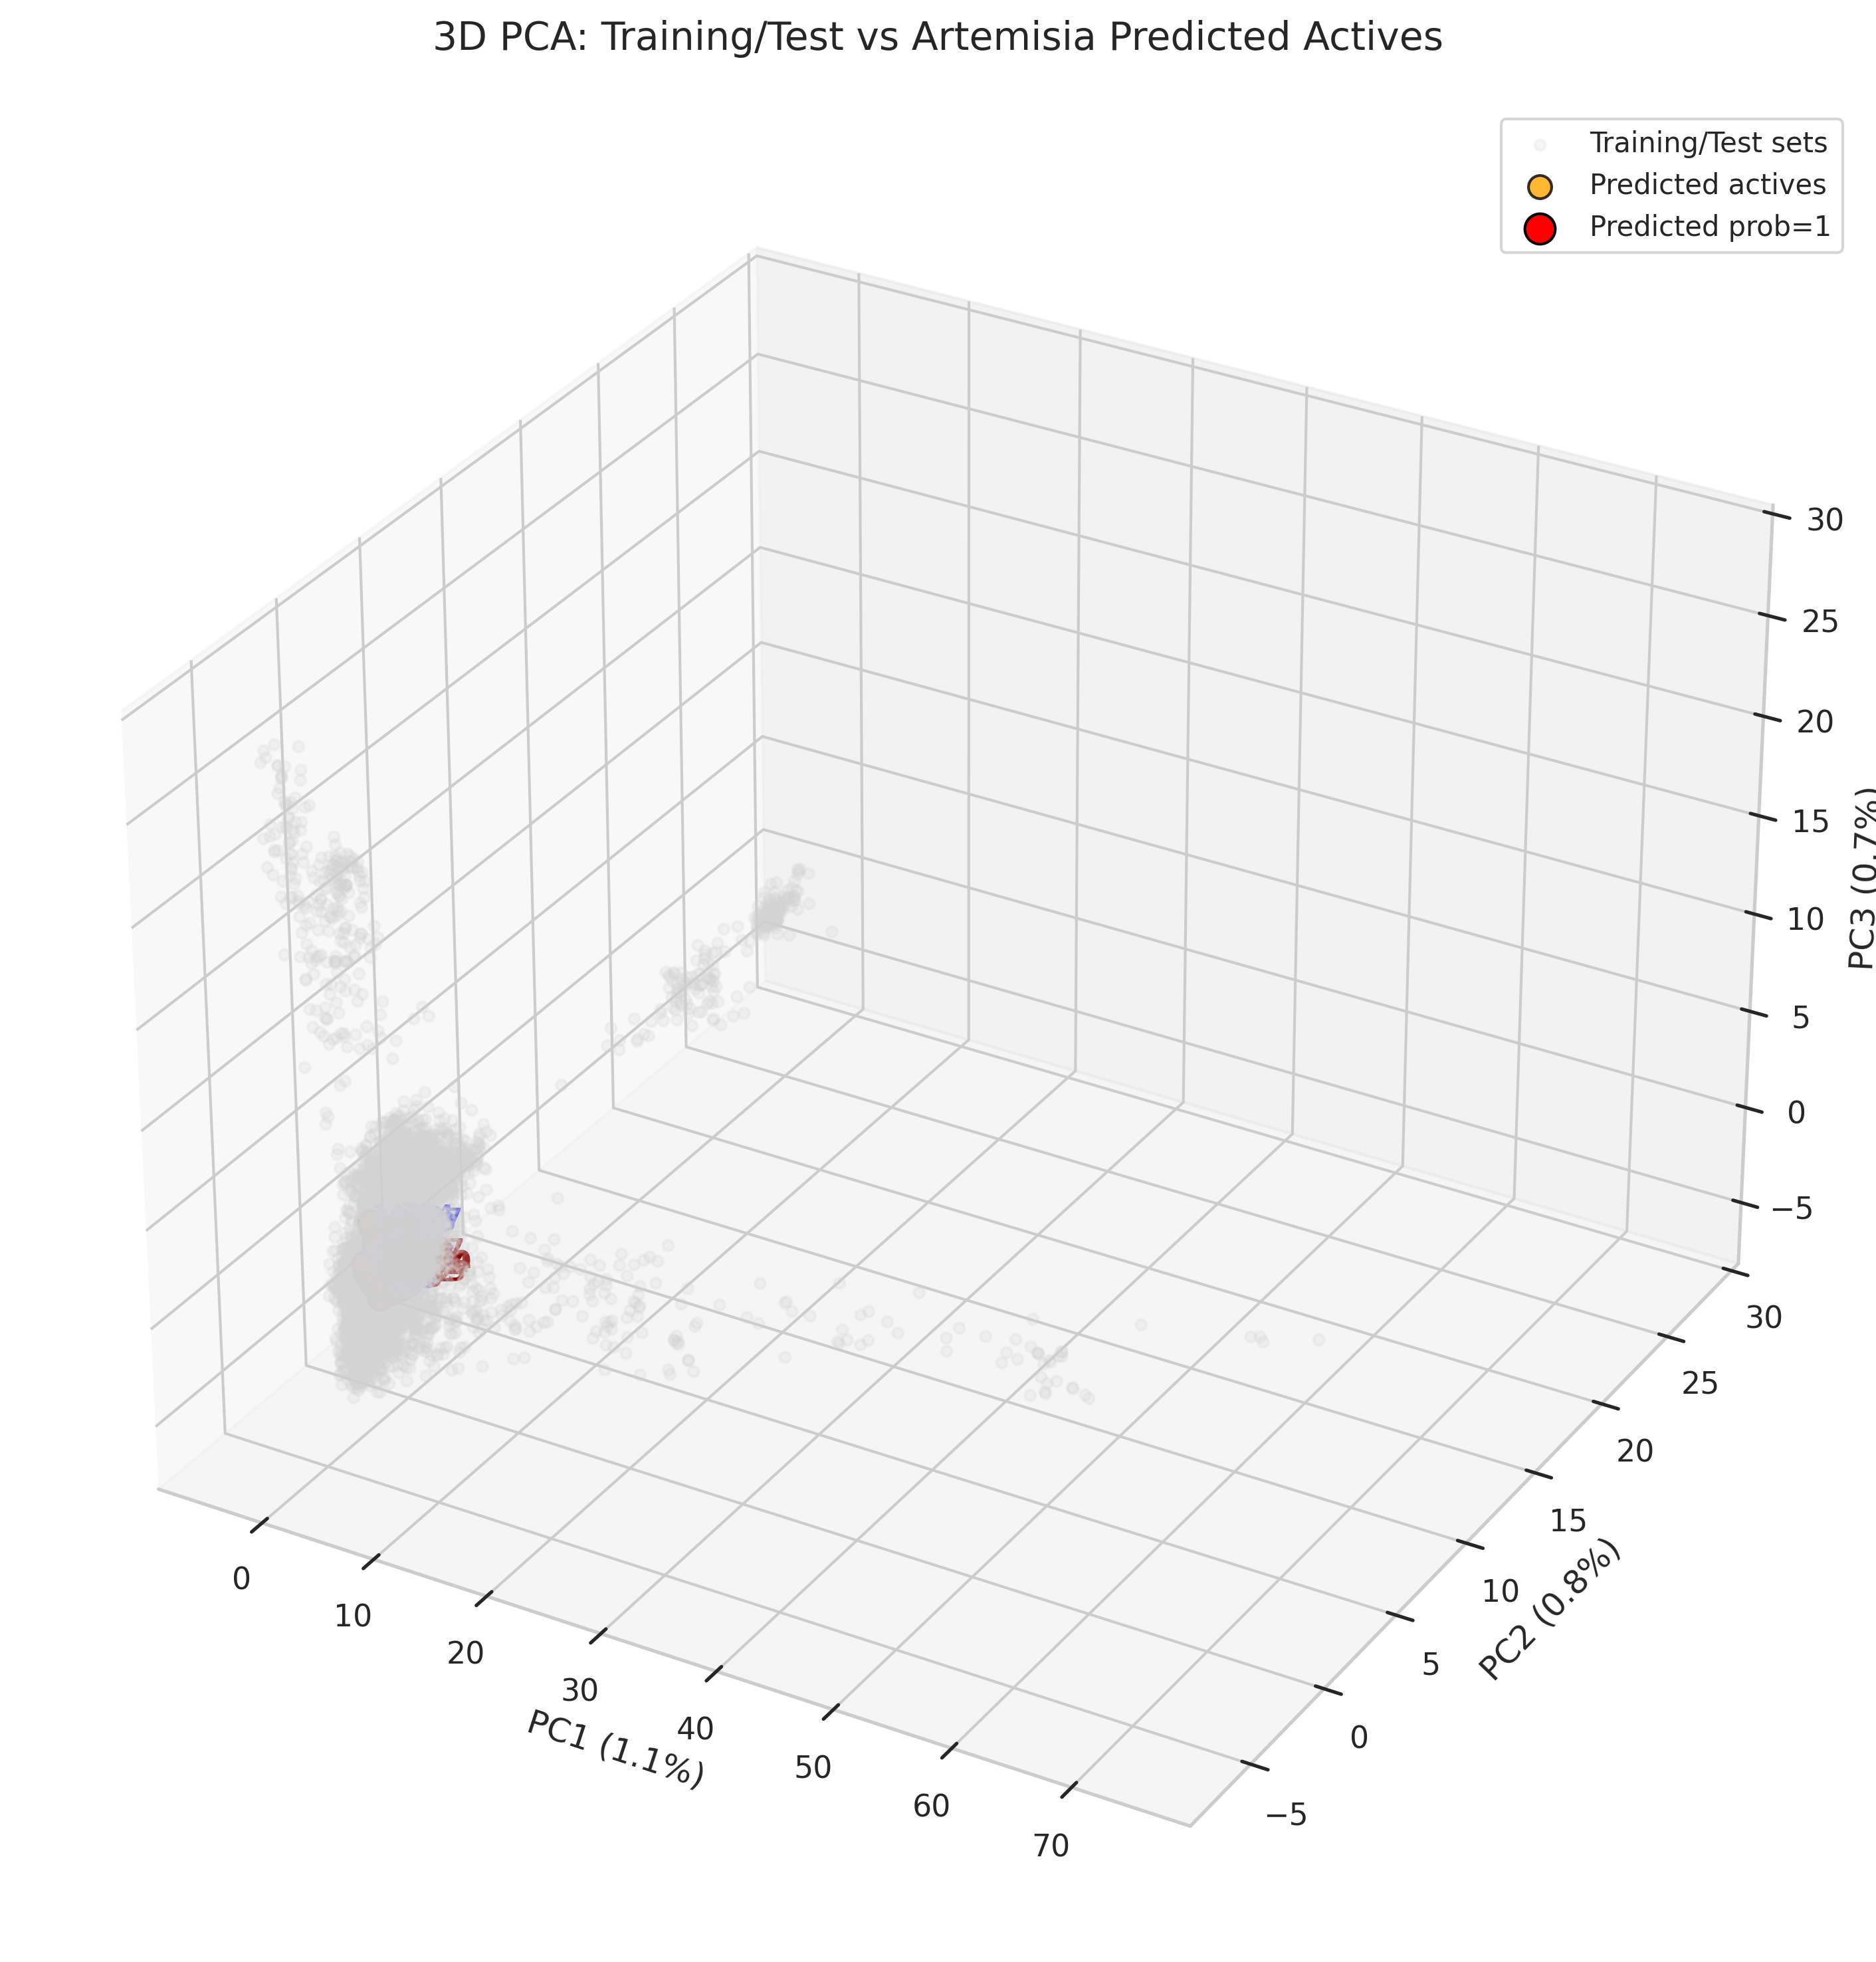

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --------------------------
# 3D PCA Plot with high visibility and transparency strategy
# --------------------------
fig = plt.figure(figsize=(12, 10), dpi=300)
ax = fig.add_subplot(111, projection='3d')

# 1. Training + Test sets: very faint gray, small markers
ax.scatter(
    X_train_pca3[:,0], X_train_pca3[:,1], X_train_pca3[:,2],
    c='lightgray', alpha=0.2, s=15, label='Training/Test sets'
)
ax.scatter(
    X_test_pca3[:,0], X_test_pca3[:,1], X_test_pca3[:,2],
    c='lightgray', alpha=0.2, s=15
)

# 2. Predicted Artemisia actives: bright orange, medium size, semi-transparent
ax.scatter(
    X_afra_actives[:,0], X_afra_actives[:,1], X_afra_actives[:,2],
    c='orange', alpha=0.8, s=70, label='Predicted actives', edgecolors='black'
)

# 3. Predicted probability=1 actives: bright red, larger size, opaque
ax.scatter(
    X_afra_prob1[:,0], X_afra_prob1[:,1], X_afra_prob1[:,2],
    c='red', alpha=1.0, s=120, label='Predicted prob=1', edgecolors='black'
)

# 4. Annotate predicted actives with numbers (blue)
for i in range(X_afra_actives.shape[0]):
    coords = X_afra_actives[i]
    ax.text(coords[0]+0.01, coords[1]+0.01, coords[2]+0.01,
            str(i+1), fontsize=9, fontweight='bold', color='blue')

# 5. Annotate prob=1 actives differently (dark red bold)
for i in range(X_afra_prob1.shape[0]):
    coords = X_afra_prob1[i]
    ax.text(coords[0]+0.02, coords[1]+0.02, coords[2]+0.02,
            f"P{i+1}", fontsize=10, fontweight='bold', color='darkred')

# 6. Axis labels with explained variance
ax.set_xlabel(f'PC1 ({explained_var[0]*100:.1f}%)', fontsize=12)
ax.set_ylabel(f'PC2 ({explained_var[1]*100:.1f}%)', fontsize=12)
ax.set_zlabel(f'PC3 ({explained_var[2]*100:.1f}%)', fontsize=12)

# 7. Title and legend
ax.set_title('3D PCA: Training/Test vs Artemisia Predicted Actives', pad=20, fontsize=14)
ax.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

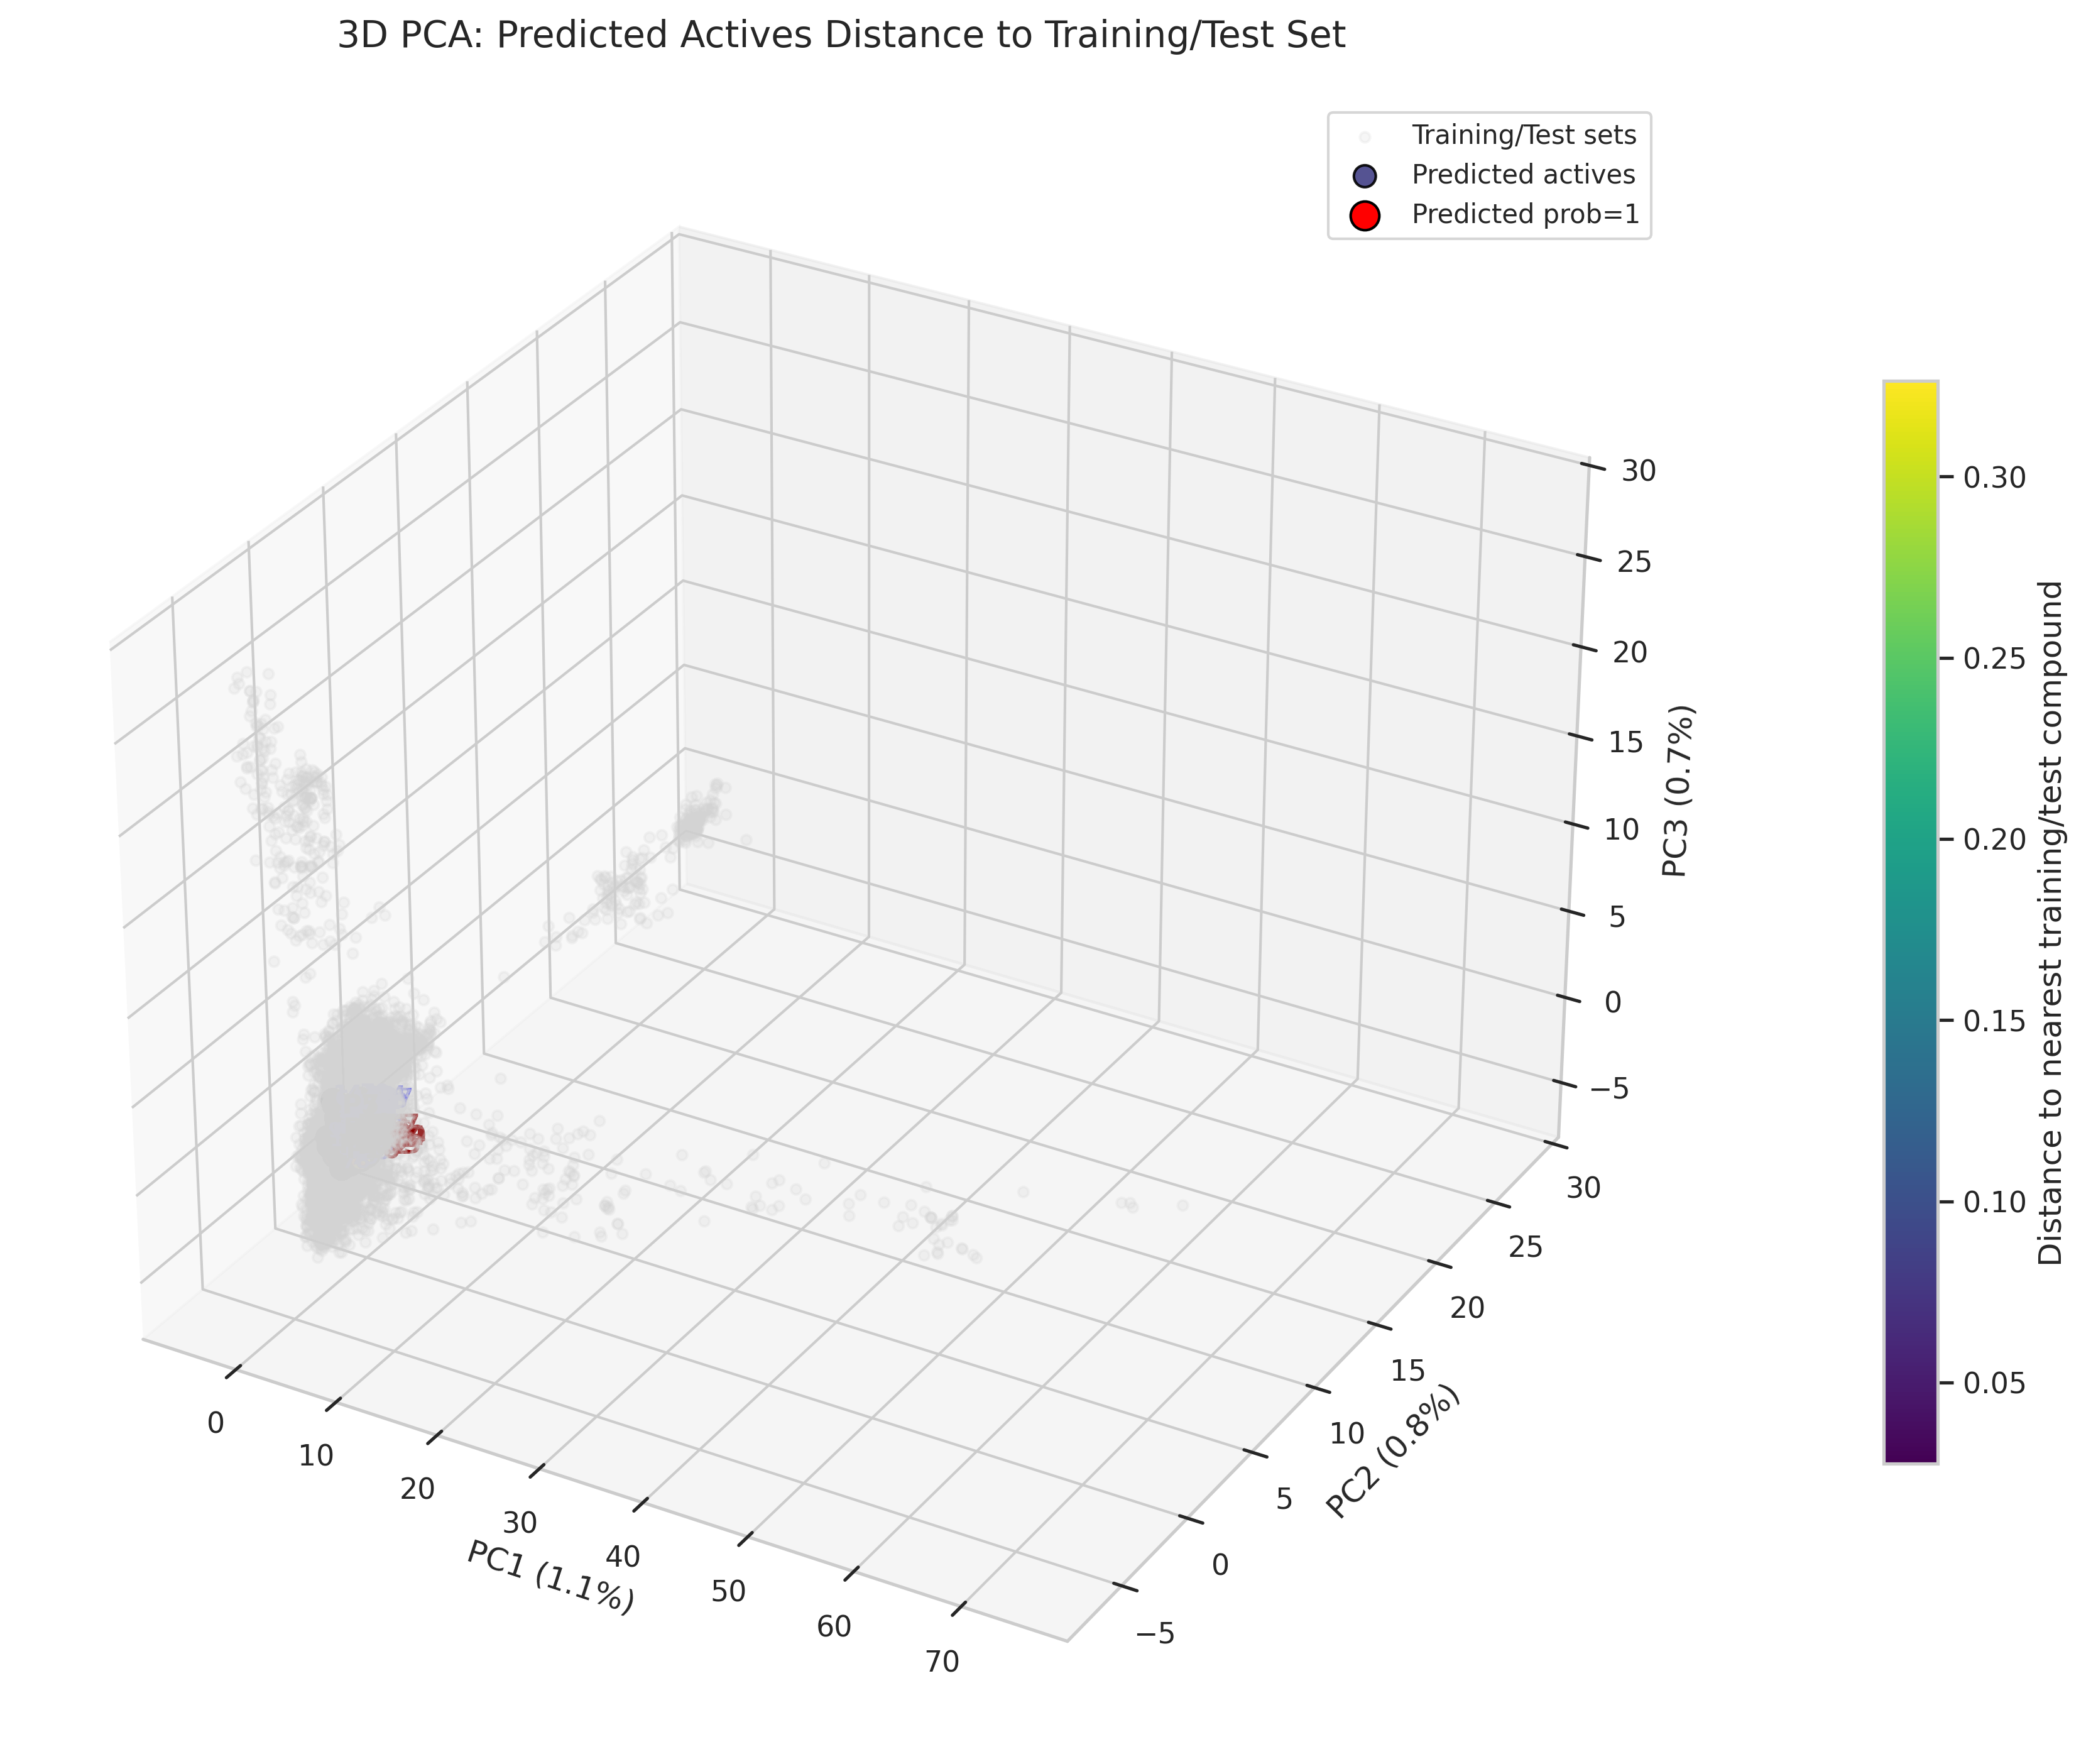

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# --------------------------
# Compute nearest distance to training/test set
# --------------------------
# Combine training and test PCA coordinates
X_train_test = np.vstack([X_train_pca3, X_test_pca3])

# Function to compute minimum Euclidean distance to training/test set
def min_distance(point, reference_set):
    return np.min(np.linalg.norm(reference_set - point, axis=1))

# Compute distances for all predicted actives
distances = np.array([min_distance(p, X_train_test) for p in X_afra_actives])

# Normalize distances for colormap
norm = plt.Normalize(vmin=np.min(distances), vmax=np.max(distances))
colors = cm.viridis(norm(distances))  # viridis: good for visibility

# --------------------------
# 3D PCA Plot with distance coloring
# --------------------------
fig = plt.figure(figsize=(12, 10), dpi=300)
ax = fig.add_subplot(111, projection='3d')

# Training/Test sets: faint gray
ax.scatter(
    X_train_pca3[:,0], X_train_pca3[:,1], X_train_pca3[:,2],
    c='lightgray', alpha=0.2, s=15, label='Training/Test sets'
)
ax.scatter(
    X_test_pca3[:,0], X_test_pca3[:,1], X_test_pca3[:,2],
    c='lightgray', alpha=0.2, s=15
)

# Predicted Artemisia actives: color-coded by distance
sc = ax.scatter(
    X_afra_actives[:,0], X_afra_actives[:,1], X_afra_actives[:,2],
    c=colors, alpha=0.9, s=70, edgecolors='black', label='Predicted actives'
)

# Predicted probability=1 actives: dark red, larger
ax.scatter(
    X_afra_prob1[:,0], X_afra_prob1[:,1], X_afra_prob1[:,2],
    c='red', alpha=1.0, s=120, edgecolors='black', label='Predicted prob=1'
)

# Annotate predicted actives with numbers
for i in range(X_afra_actives.shape[0]):
    coords = X_afra_actives[i]
    ax.text(coords[0]+0.01, coords[1]+0.01, coords[2]+0.01,
            str(i+1), fontsize=8, fontweight='bold', color='blue')

# Annotate prob=1 actives
for i in range(X_afra_prob1.shape[0]):
    coords = X_afra_prob1[i]
    ax.text(coords[0]+0.02, coords[1]+0.02, coords[2]+0.02,
            f"P{i+1}", fontsize=10, fontweight='bold', color='darkred')

# Axis labels with explained variance
ax.set_xlabel(f'PC1 ({explained_var[0]*100:.1f}%)', fontsize=12)
ax.set_ylabel(f'PC2 ({explained_var[1]*100:.1f}%)', fontsize=12)
ax.set_zlabel(f'PC3 ({explained_var[2]*100:.1f}%)', fontsize=12)

# Title and legend
ax.set_title('3D PCA: Predicted Actives Distance to Training/Test Set', pad=20, fontsize=14)
ax.legend(loc='upper right', fontsize=10)

# Colorbar for distances
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap='viridis'), ax=ax, shrink=0.6, pad=0.1)
cbar.set_label('Distance to nearest training/test compound', fontsize=12)

plt.tight_layout()
plt.show()


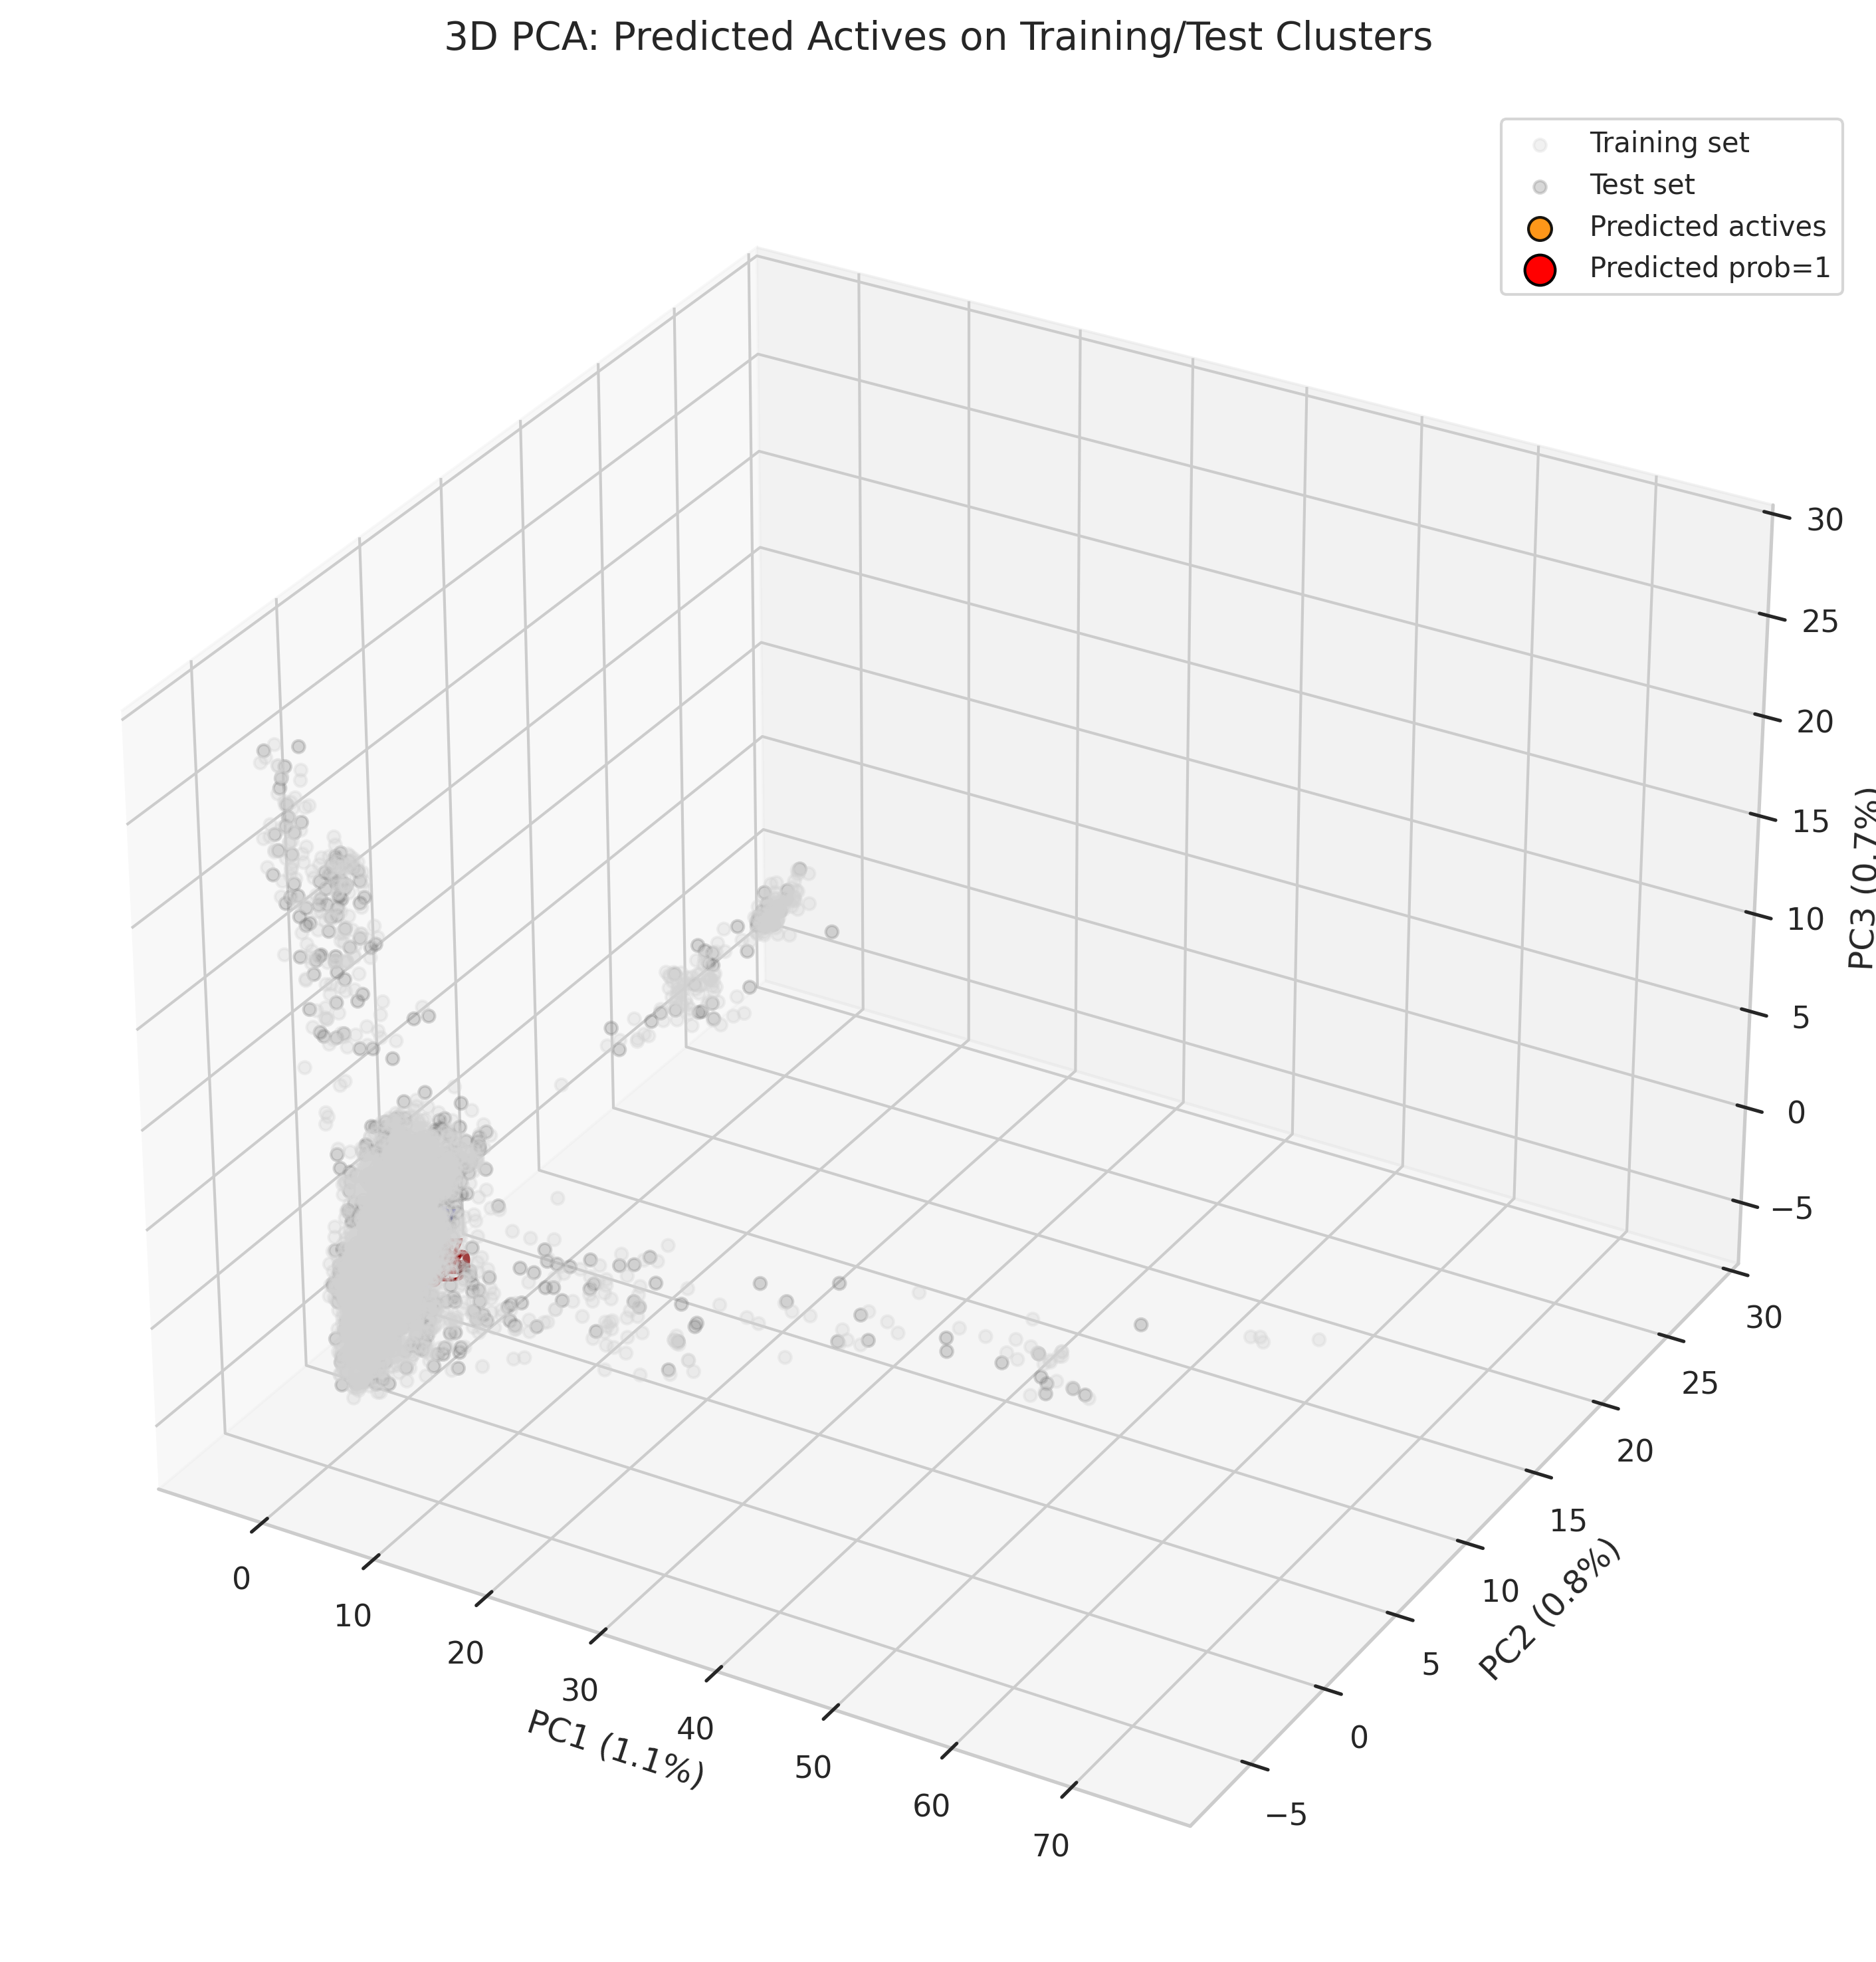

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --------------------------
# 3D PCA Plot: Training/Test + Predicted Actives
# --------------------------
fig = plt.figure(figsize=(12, 10), dpi=300)
ax = fig.add_subplot(111, projection='3d')

# Training set: light gray
ax.scatter(
    X_train_pca3[:,0], X_train_pca3[:,1], X_train_pca3[:,2],
    c='lightgray', alpha=0.3, s=20, label='Training set'
)

# Test set: slightly darker gray
ax.scatter(
    X_test_pca3[:,0], X_test_pca3[:,1], X_test_pca3[:,2],
    c='gray', alpha=0.3, s=20, label='Test set'
)

# Predicted actives: orange dots on top
ax.scatter(
    X_afra_actives[:,0], X_afra_actives[:,1], X_afra_actives[:,2],
    c='#FF8C00', alpha=0.9, s=70, edgecolors='black', label='Predicted actives'
)

# Predicted prob=1 actives: larger red dots
ax.scatter(
    X_afra_prob1[:,0], X_afra_prob1[:,1], X_afra_prob1[:,2],
    c='red', alpha=1.0, s=120, edgecolors='black', label='Predicted prob=1'
)

# Annotate predicted actives
for i, coord in enumerate(X_afra_actives):
    ax.text(coord[0]+0.01, coord[1]+0.01, coord[2]+0.01,
            str(i+1), fontsize=8, fontweight='bold', color='blue')

# Annotate prob=1 actives
for i, coord in enumerate(X_afra_prob1):
    ax.text(coord[0]+0.02, coord[1]+0.02, coord[2]+0.02,
            f"P{i+1}", fontsize=10, fontweight='bold', color='darkred')

# Axis labels with explained variance
ax.set_xlabel(f'PC1 ({explained_var[0]*100:.1f}%)', fontsize=12)
ax.set_ylabel(f'PC2 ({explained_var[1]*100:.1f}%)', fontsize=12)
ax.set_zlabel(f'PC3 ({explained_var[2]*100:.1f}%)', fontsize=12)

# Title and legend
ax.set_title('3D PCA: Predicted Actives on Training/Test Clusters', pad=20, fontsize=14)
ax.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# --------------------------
# Compute nearest distance to training/test set
# --------------------------
# Combine training and test PCA coordinates
X_train_test_2d = np.vstack([X_train_pca2, X_test_pca2])  # Use 2 PCs now

# Function to compute minimum Euclidean distance to training/test set
def min_distance(point, reference_set):
    return np.min(np.linalg.norm(reference_set - point, axis=1))

# Compute distances for all predicted actives
distances = np.array([min_distance(p, X_train_test_2d) for p in X_afra_actives_2d])

# Normalize distances for colormap
norm = plt.Normalize(vmin=np.min(distances), vmax=np.max(distances))
colors = cm.viridis(norm(distances))

# --------------------------
# 2D PCA Plot with distance coloring
# --------------------------
plt.figure(figsize=(10, 8), dpi=300)

# Training/Test sets: faint gray
plt.scatter(
    X_train_pca2[:,0], X_train_pca2[:,1],
    c='lightgray', alpha=0.2, s=15, label='Training/Test sets'
)
plt.scatter(
    X_test_pca2[:,0], X_test_pca2[:,1],
    c='lightgray', alpha=0.2, s=15
)

# Predicted Artemisia actives: color-coded by distance
plt.scatter(
    X_afra_actives_2d[:,0], X_afra_actives_2d[:,1],
    c=colors, alpha=0.9, s=70, edgecolors='black', label='Predicted actives'
)

# Predicted probability=1 actives: dark red, larger
plt.scatter(
    X_afra_prob1_2d[:,0], X_afra_prob1_2d[:,1],
    c='red', alpha=1.0, s=120, edgecolors='black', label='Predicted prob=1'
)

# Annotate predicted actives with numbers
for i in range(X_afra_actives_2d.shape[0]):
    coords = X_afra_actives_2d[i]
    plt.text(coords[0]+0.01, coords[1]+0.01,
             str(i+1), fontsize=8, fontweight='bold', color='blue')

# Annotate prob=1 actives
for i in range(X_afra_prob1_2d.shape[0]):
    coords = X_afra_prob1_2d[i]
    plt.text(coords[0]+0.02, coords[1]+0.02,
             f"P{i+1}", fontsize=10, fontweight='bold', color='darkred')

# Axis labels with explained variance
plt.xlabel(f'PC1 ({explained_var[0]*100:.1f}%)', fontsize=12)
plt.ylabel(f'PC2 ({explained_var[1]*100:.1f}%)', fontsize=12)

# Title and legend
plt.title('2D PCA: Predicted Actives Distance to Training/Test Set', fontsize=14)
plt.legend(loc='upper right', fontsize=10)

# Colorbar for distances
cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap='viridis'))
cbar.set_label('Distance to nearest training/test compound', fontsize=12)

plt.tight_layout()
plt.show()


NameError: name 'X_train_pca2' is not defined

In [ ]:
from sklearn.decomposition import PCA

# Suppose X_train and X_test are your original descriptor matrices
X_all = np.vstack([X_train, X_test])  # Combine for consistent PCA

# Fit PCA with 2 components
pca2 = PCA(n_components=2)
X_all_pca2 = pca2.fit_transform(X_all)

# Split back into training and test sets
X_train_pca2 = X_all_pca2[:X_train.shape[0]]
X_test_pca2 = X_all_pca2[X_train.shape[0]:]

# Transform predicted actives as well
X_afra_actives_2d = pca2.transform(X_afra_actives)
X_afra_prob1_2d = pca2.transform(X_afra_prob1)

# Explained variance for axis labels
explained_var = pca2.explained_variance_ratio_


ValueError: X has 3 features, but PCA is expecting 2048 features as input.

In [3]:
afra_results = pd.read_csv('/content/afra_results.csv')

In [4]:
top_active = pd.read_csv('/content/top_afra_prob1.csv')

In [5]:
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
import pandas as pd

def lipinski_analysis(df, smiles_col='canonical_smiles'):
    data = []

    for _, row in df.iterrows():
        mol = Chem.MolFromSmiles(row[smiles_col])
        if mol is None:
            continue

        mw = Descriptors.MolWt(mol)
        logp = Descriptors.MolLogP(mol)
        hbd = Lipinski.NumHDonors(mol)
        hba = Lipinski.NumHAcceptors(mol)

        violations = sum([
            mw > 500,
            logp > 5,
            hbd > 5,
            hba > 10
        ])

        data.append({
            'MW': mw,
            'LogP': logp,
            'HBD': hbd,
            'HBA': hba,
            'Lipinski_Violations': violations
        })

    return pd.concat([df.reset_index(drop=True), pd.DataFrame(data)], axis=1)

In [6]:
top_active_lipinski = lipinski_analysis(top_active, smiles_col='canonical_smiles')

In [25]:
top_active_lipinski.to_csv("top_active_lipinski_violation.csv", index=False)

In [7]:
top_active_lipinski

afra_compounds  \
0              Glucuronic acid   
1                       Fucose   
2            Galacturonic acid   
3                     geraniol   
4                      Glucose   
5          isoamyl isovalerate   
6                Isononadecano   
7                   lavandulol   
8                     linalool   
9             linalool acetate   
10                     Mannose   
11           artemisyl acetate   
12            artemisia ketone   
13           artemisia alcohol   
14           methyl linolenate   
15                     myrcene   
16                 octadecanol   
17                    Rhamnose   
18           santolina alcohol   
19            santolina triene   
20          santolinyl acetate   
21   4-O-Methylglucuronic acid   
22                   tricosane   
23  2-methyl butyl isovalerate   
24              yomogi alcohol   
25                1-octen-3-ol   
26               1-Octacosanol   
27                   Galactose   

                                  canonical_smiles  \
0    [C@@H]1([C@@H]([C@H](OC([C@@H]1O)O)C(=O)O)O)O   
1         C[C@H]1[C@H]([C@H]([C@@H](C(O1)O)O)O)O     
2   C(=O)[C@@H]([C@H]([C@H]([C@@H](C(=O)O)O)O)O)O    
3                             CC(=CCC/C(=C/CO)/C)C   
4     C([C@@H]1[C@H]([C@@H]([C@H](C(O1)O)O)O)O)O     
5                            CC(C)CCOC(=O)CC(C)C     
6                  CC(C)CCCCCCCCCCCCCCCC(=O)[O-]     
7                       CC(=CC[C@@H](CO)C(=C)C)C     
8                              CC(=CCCC(C)(C=C)O)C   
9                      CC(=CCCC(C)(C=C)OC(=O)C)C     
10   C([C@@H]1[C@H]([C@@H]([C@@H](C(O1)O)O)O)O)O     
11                     CC(=CC(C(C)(C)C=C)OC(=O)C)C   
12                         CC(=CC(=O)C(C)(C)C=C)C    
13                     CC(=CC(C(C)(C)C=C)OC(=O)C)C   
14               CC/C=C\C/C=C\C/C=C\CCCCCCCC(=O)OC   
15                             CC(=CCCC(=C)C=C)C     
16                             CCCCCCCCCCCCCCCCCCO   
17          C[C@H]1[C@@H]([C@H]([C@H](C(O1)O)O)O)O   
18                          CC(=CC(C=C)C(C)(C)O)C    
19                           CC(=CC(C=C)C(=C)C)C     
20                     CC(=CC(C=C)C(C)(C)OC(=O)C)C   
21  CO[C@@H]([C@@H]([C@H](C=O)O)O)[C@@H](C(=O)O)O    
22                         CCCCCCCCCCCCCCCCCCCCCCC   
23                             CCC(C)COC(=O)CC(C)C   
24                       CC(C)(C=C)/C=C/C(C)(C)O     
25                                    CCCCCC(C=C)O   
26                   CCCCCCCCCCCCCCCCCCCCCCCCCCCCO   
27     C([C@@H]1[C@@H]([C@@H]([C@H](C(O1)O)O)O)O)O   

                                                 mol  \
0   <rdkit.Chem.rdchem.Mol object at 0x7a309a25d9a0>   
1   <rdkit.Chem.rdchem.Mol object at 0x7a309a25d5b0>   
2   <rdkit.Chem.rdchem.Mol object at 0x7a309a25d690>   
3   <rdkit.Chem.rdchem.Mol object at 0x7a309a25d700>   
4   <rdkit.Chem.rdchem.Mol object at 0x7a309a25d930>   
5   <rdkit.Chem.rdchem.Mol object at 0x7a309a25daf0>   
6   <rdkit.Chem.rdchem.Mol object at 0x7a309a25db60>   
7   <rdkit.Chem.rdchem.Mol object at 0x7a309a25dc40>   
8   <rdkit.Chem.rdchem.Mol object at 0x7a309a25dd20>   
9   <rdkit.Chem.rdchem.Mol object at 0x7a309a25dd90>   
10  <rdkit.Chem.rdchem.Mol object at 0x7a309a25de00>   
11  <rdkit.Chem.rdchem.Mol object at 0x7a309a25c430>   
12  <rdkit.Chem.rdchem.Mol object at 0x7a309a25c3c0>   
13  <rdkit.Chem.rdchem.Mol object at 0x7a309a25c900>   
14  <rdkit.Chem.rdchem.Mol object at 0x7a309a25dee0>   
15  <rdkit.Chem.rdchem.Mol object at 0x7a309a25df50>   
16  <rdkit.Chem.rdchem.Mol object at 0x7a309a25e0a0>   
17  <rdkit.Chem.rdchem.Mol object at 0x7a309a25e6c0>   
18  <rdkit.Chem.rdchem.Mol object at 0x7a309a25e960>   
19  <rdkit.Chem.rdchem.Mol object at 0x7a309a25e9d0>   
20  <rdkit.Chem.rdchem.Mol object at 0x7a309a25ea40>   
21  <rdkit.Chem.rdchem.Mol object at 0x7a309a25c7b0>   
22  <rdkit.Chem.rdchem.Mol object at 0x7a309a25f140>   
23  <rdkit.Chem.rdchem.Mol object at 0x7a309a25c740>   
24  <rdkit.Chem.rdchem.Mol object at 0x7a309a25f300>   
25  <r

In [8]:
zero_violation_compounds = top_active_lipinski[
    top_active_lipinski['Lipinski_Violations'] == 0
]

print(f"Number of compounds with zero Lipinski violations: {len(zero_violation_compounds)}")


Number of compounds with zero Lipinski violations: 23


In [26]:
zero_violation_compounds.to_csv("zero_violation_compounds_draw_struc_docking.csv", index=False)

In [10]:
zero_violation_compounds

afra_compounds  \
0              Glucuronic acid   
1                       Fucose   
2            Galacturonic acid   
3                     geraniol   
4                      Glucose   
5          isoamyl isovalerate   
7                   lavandulol   
8                     linalool   
9             linalool acetate   
10                     Mannose   
11           artemisyl acetate   
12            artemisia ketone   
13           artemisia alcohol   
15                     myrcene   
17                    Rhamnose   
18           santolina alcohol   
19            santolina triene   
20          santolinyl acetate   
21   4-O-Methylglucuronic acid   
23  2-methyl butyl isovalerate   
24              yomogi alcohol   
25                1-octen-3-ol   
27                   Galactose   

                                  canonical_smiles  \
0    [C@@H]1([C@@H]([C@H](OC([C@@H]1O)O)C(=O)O)O)O   
1         C[C@H]1[C@H]([C@H]([C@@H](C(O1)O)O)O)O     
2   C(=O)[C@@H]([C@H]([C@H]([C@@H](C(=O)O)O)O)O)O    
3                             CC(=CCC/C(=C/CO)/C)C   
4     C([C@@H]1[C@H]([C@@H]([C@H](C(O1)O)O)O)O)O     
5                            CC(C)CCOC(=O)CC(C)C     
7                       CC(=CC[C@@H](CO)C(=C)C)C     
8                              CC(=CCCC(C)(C=C)O)C   
9                      CC(=CCCC(C)(C=C)OC(=O)C)C     
10   C([C@@H]1[C@H]([C@@H]([C@@H](C(O1)O)O)O)O)O     
11                     CC(=CC(C(C)(C)C=C)OC(=O)C)C   
12                         CC(=CC(=O)C(C)(C)C=C)C    
13                     CC(=CC(C(C)(C)C=C)OC(=O)C)C   
15                             CC(=CCCC(=C)C=C)C     
17          C[C@H]1[C@@H]([C@H]([C@H](C(O1)O)O)O)O   
18                          CC(=CC(C=C)C(C)(C)O)C    
19                           CC(=CC(C=C)C(=C)C)C     
20                     CC(=CC(C=C)C(C)(C)OC(=O)C)C   
21  CO[C@@H]([C@@H]([C@H](C=O)O)O)[C@@H](C(=O)O)O    
23                             CCC(C)COC(=O)CC(C)C   
24                       CC(C)(C=C)/C=C/C(C)(C)O     
25                                    CCCCCC(C=C)O   
27     C([C@@H]1[C@@H]([C@@H]([C@H](C(O1)O)O)O)O)O   

                                                 mol  \
0   <rdkit.Chem.rdchem.Mol object at 0x7a309a25d9a0>   
1   <rdkit.Chem.rdchem.Mol object at 0x7a309a25d5b0>   
2   <rdkit.Chem.rdchem.Mol object at 0x7a309a25d690>   
3   <rdkit.Chem.rdchem.Mol object at 0x7a309a25d700>   
4   <rdkit.Chem.rdchem.Mol object at 0x7a309a25d930>   
5   <rdkit.Chem.rdchem.Mol object at 0x7a309a25daf0>   
7   <rdkit.Chem.rdchem.Mol object at 0x7a309a25dc40>   
8   <rdkit.Chem.rdchem.Mol object at 0x7a309a25dd20>   
9   <rdkit.Chem.rdchem.Mol object at 0x7a309a25dd90>   
10  <rdkit.Chem.rdchem.Mol object at 0x7a309a25de00>   
11  <rdkit.Chem.rdchem.Mol object at 0x7a309a25c430>   
12  <rdkit.Chem.rdchem.Mol object at 0x7a309a25c3c0>   
13  <rdkit.Chem.rdchem.Mol object at 0x7a309a25c900>   
15  <rdkit.Chem.rdchem.Mol object at 0x7a309a25df50>   
17  <rdkit.Chem.rdchem.Mol object at 0x7a309a25e6c0>   
18  <rdkit.Chem.rdchem.Mol object at 0x7a309a25e960>   
19  <rdkit.Chem.rdchem.Mol object at 0x7a309a25e9d0>   
20  <rdkit.Chem.rdchem.Mol object at 0x7a309a25ea40>   
21  <rdkit.Chem.rdchem.Mol object at 0x7a309a25c7b0>   
23  <rdkit.Chem.rdchem.Mol object at 0x7a309a25c740>   
24  <rdkit.Chem.rdchem.Mol object at 0x7a309a25f300>   
25  <rdkit.Chem.rdchem.Mol object at 0x7a309a25c6d0>   
27  <rdkit.Chem.rdchem.Mol object at 0x7a309a25d620>   

                                            morgan_fp  Predicted_Probability  \
0   <rdkit.DataStructs.cDataStructs.ExplicitBitVec...                    1.0   
1   <rdkit.DataStructs.cDataStructs.ExplicitBitVec...                    1.0   
2   <rdkit.DataStructs.cDataStructs.ExplicitBitVec...                    1.0   
3   <rdkit.DataStructs.cDataStructs.ExplicitBitVec...                    1.0   
4   <rdkit.DataStructs.cDataStructs.ExplicitBitVec...                    1.0   
5   <rdkit.DataStructs.cDataStructs.ExplicitBitVec...                    1.0 

In [29]:
zero_violation_compounds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23 entries, 0 to 27
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   afra_compounds         23 non-null     object 
 1   canonical_smiles       23 non-null     object 
 2   mol                    23 non-null     object 
 3   morgan_fp              23 non-null     object 
 4   Predicted_Probability  23 non-null     float64
 5   Predicted_Class        23 non-null     int64  
 6   MW                     23 non-null     float64
 7   LogP                   23 non-null     float64
 8   HBD                    23 non-null     int64  
 9   HBA                    23 non-null     int64  
 10  Lipinski_Violations    23 non-null     int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 2.2+ KB


In [9]:
lipinski_summary = top_active_lipinski['Lipinski_Violations'].value_counts().sort_index()
lipinski_summary

Lipinski_Violations
0    23
1     5
Name: count, dtype: int64

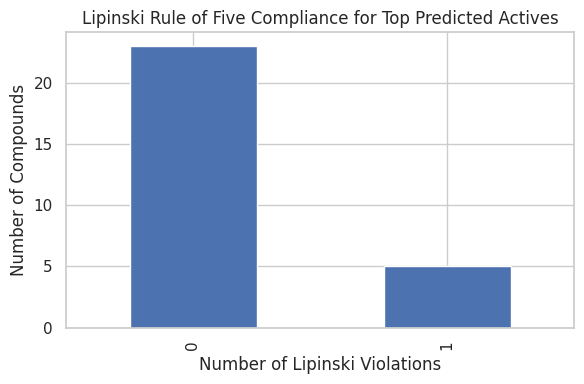

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
lipinski_summary.plot(kind='bar')

plt.xlabel('Number of Lipinski Violations')
plt.ylabel('Number of Compounds')
plt.title('Lipinski Rule of Five Compliance for Top Predicted Actives')
plt.tight_layout()
plt.show()

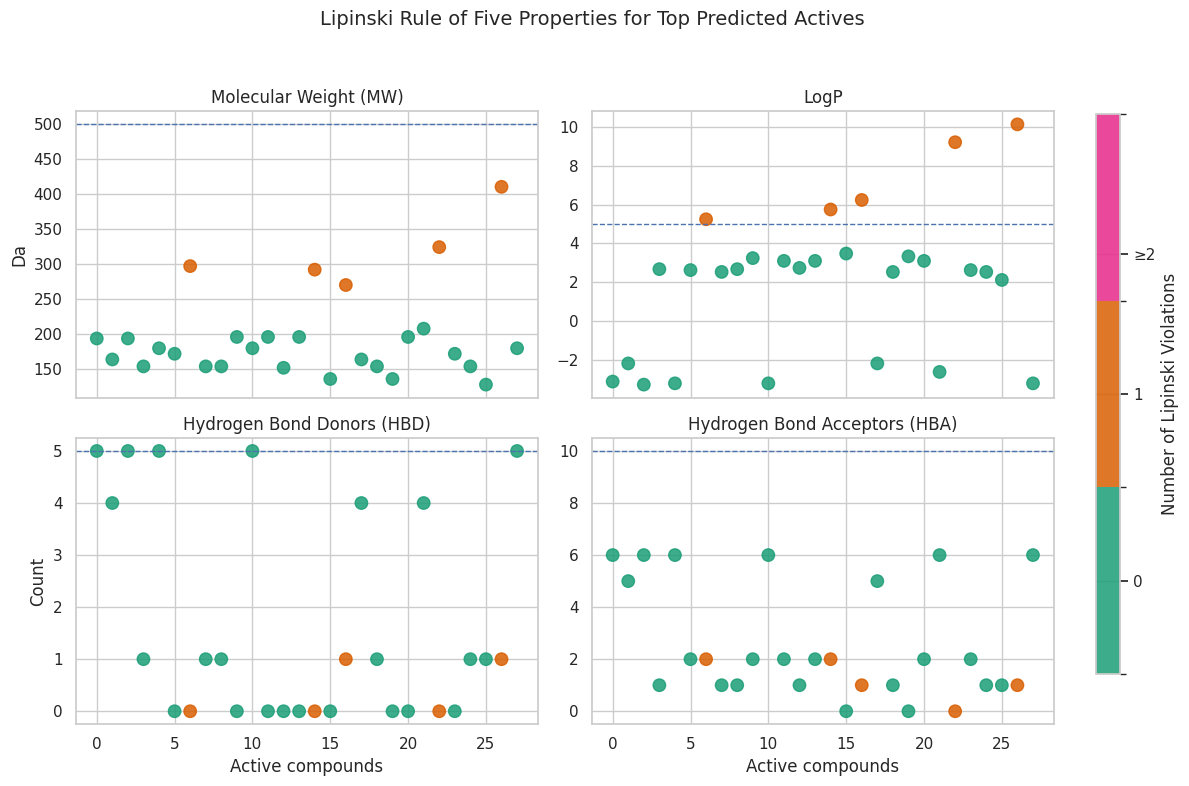

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm

violations = top_active_lipinski['Lipinski_Violations']
idx = range(len(top_active_lipinski))

# ---- Discrete, visible colors for violations ----
# 0 violations = green, 1 = orange, ≥2 = red
cmap = ListedColormap(['#1b9e77', '#d95f02', '#e7298a'])
bounds = [-0.5, 0.5, 1.5, 3.5]
norm = BoundaryNorm(bounds, cmap.N)

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

# -------- MW --------
sc = axes[0, 0].scatter(
    idx, top_active_lipinski['MW'],
    c=violations, cmap=cmap, norm=norm, s=80, alpha=0.85
)
axes[0, 0].axhline(500, linestyle='--', linewidth=1)
axes[0, 0].set_title('Molecular Weight (MW)')
axes[0, 0].set_ylabel('Da')

# -------- LogP --------
axes[0, 1].scatter(
    idx, top_active_lipinski['LogP'],
    c=violations, cmap=cmap, norm=norm, s=80, alpha=0.85
)
axes[0, 1].axhline(5, linestyle='--', linewidth=1)
axes[0, 1].set_title('LogP')

# -------- HBD --------
axes[1, 0].scatter(
    idx, top_active_lipinski['HBD'],
    c=violations, cmap=cmap, norm=norm, s=80, alpha=0.85
)
axes[1, 0].axhline(5, linestyle='--', linewidth=1)
axes[1, 0].set_title('Hydrogen Bond Donors (HBD)')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_xlabel('Active compounds')

# -------- HBA --------
axes[1, 1].scatter(
    idx, top_active_lipinski['HBA'],
    c=violations, cmap=cmap, norm=norm, s=80, alpha=0.85
)
axes[1, 1].axhline(10, linestyle='--', linewidth=1)
axes[1, 1].set_title('Hydrogen Bond Acceptors (HBA)')
axes[1, 1].set_xlabel('Active compounds')

# -------- External colorbar --------
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sc, cax=cbar_ax, ticks=[0, 1, 2])
cbar.set_label('Number of Lipinski Violations')
cbar.set_ticklabels(['0', '1', '≥2'])

fig.suptitle(
    'Lipinski Rule of Five Properties for Top Predicted Actives',
    fontsize=14
)

plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()

In [10]:
from docx import Document

doc1 = Document()
doc1.add_heading('Virtual Screening Results of Artemisia afra', level=1)

table1 = doc1.add_table(rows=1, cols=len(afra_results.columns))
table1.style = 'Table Grid'

# Header
for i, col in enumerate(afra_results.columns):
    table1.rows[0].cells[i].text = str(col)

# Data
for _, row in afra_results.iterrows():
    cells = table1.add_row().cells
    for i, val in enumerate(row):
        cells[i].text = str(val)

doc1.save('Artemisia_afra_all_screening_results.docx')


In [11]:
from docx import Document

doc2 = Document()
doc2.add_heading('Top Predicted Epigenetic Modifiers from Artemisia afra', level=1)

table2 = doc2.add_table(rows=1, cols=len(top_active.columns))
table2.style = 'Table Grid'

# Header
for i, col in enumerate(top_active.columns):
    table2.rows[0].cells[i].text = str(col)

# Data
for _, row in top_active.iterrows():
    cells = table2.add_row().cells
    for i, val in enumerate(row):
        cells[i].text = str(val)

doc2.save('Artemisia_afra_top_predicted_actives.docx')

In [3]:
!pip install python-docx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 4.0 MB/s eta 0:00:00


In [4]:
df = pd.read_csv('/content/top_active_lipinski_violation.csv')

In [5]:
import pandas as pd
from docx import Document
from docx.shared import Inches

# -----------------------------
# Function to export DataFrame to Word
# -----------------------------
def dataframe_to_word(df, filename="dataframe_output.docx", title="Data Frame Table"):
    doc = Document()

    # Add title
    doc.add_heading(title, level=1)

    # Add table
    table = doc.add_table(rows=1, cols=len(df.columns))
    table.style = "Table Grid"

    # Add header row
    hdr_cells = table.rows[0].cells
    for i, col in enumerate(df.columns):
        hdr_cells[i].text = str(col)

    # Add data rows
    for _, row in df.iterrows():
        row_cells = table.add_row().cells
        for i, value in enumerate(row):
            row_cells[i].text = str(value)

    # Save document
    doc.save(filename)
    print(f"Word document saved as: {filename}")

# -----------------------------
# Usage
# -----------------------------
dataframe_to_word(
    df,
    filename="df_output.docx",
    title="Summary of Selected Compounds"
)

Word document saved as: df_output.docx


#### Scaffold attempt

In [30]:
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
import pandas as pd

In [31]:
def get_bemis_murcko_scaffold(mol):
    try:
        scaffold = MurckoScaffold.GetScaffoldForMol(mol)
        return Chem.MolToSmiles(scaffold)
    except:
        return None

In [32]:
zero_violation_compounds["Murcko_Scaffold"] = zero_violation_compounds["mol"].apply(
    get_bemis_murcko_scaffold
)

In [34]:
def heavy_atom_count(smiles):
    if smiles is None:
        return 0
    mol = Chem.MolFromSmiles(smiles)
    return mol.GetNumHeavyAtoms() if mol else 0


In [35]:
zero_violation_compounds["Scaffold_HeavyAtoms"] = zero_violation_compounds["Murcko_Scaffold"].apply(
    heavy_atom_count
)

In [36]:
scaffold_df = zero_violation_compounds[
    zero_violation_compounds["Scaffold_HeavyAtoms"] >= 6
].copy()

In [37]:
scaffold_counts = (
    scaffold_df["Murcko_Scaffold"]
    .value_counts()
    .reset_index()
)

scaffold_counts.columns = ["Scaffold_SMILES", "Count"]
scaffold_counts

Empty DataFrame
Columns: [Scaffold_SMILES, Count]
Index: []

In [39]:
scaffold_df = zero_violation_compounds[
    zero_violation_compounds["Scaffold_HeavyAtoms"] >= 6
].copy()


In [40]:
scaffold_df

Empty DataFrame
Columns: [afra_compounds, canonical_smiles, mol, morgan_fp, Predicted_Probability, Predicted_Class, MW, LogP, HBD, HBA, Lipinski_Violations, Murcko_Scaffold, Scaffold_HeavyAtoms]
Index: []

In [41]:
type(zero_violation_compounds.loc[0, "mol"])

str

In [38]:
M = scaffold_df.shape[0]
N = scaffold_counts.shape[0]
Nsing = (scaffold_counts["Count"] == 1).sum()

scaffold_diversity = N / M
scaffold_novelty = Nsing / M

ZeroDivisionError: division by zero